In [1]:
# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98

# Fig1

## Final

In [4]:
def remove_outliers(df, col_name):
    out_hids = set()
    for i in range(0,0):
        df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

        # normalization
        from sklearn.preprocessing import StandardScaler
        
        sc = StandardScaler()
        znorm = sc.fit_transform(df2[[col_name]]).flatten()
        out_mask = (znorm > 2) | (znorm < -2)

        #std0, mean0 = df2.std()[0], df2.mean()[0]
        #print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
        out_hids = out_hids | set((df2['hid'].values)[out_mask])

        
    for i in range(0,10):
        df2 = df.loc[df['age']==i, [col_name,'hid']]

        # normalization
        from sklearn.preprocessing import StandardScaler
        
        sc = StandardScaler()
        znorm = sc.fit_transform(df2[[col_name]]).flatten()
        out_mask = (znorm > 2) | (znorm < -2)

        #std0, mean0 = df2.std()[0], df2.mean()[0]
        #print(f'age {i}~{i+1}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
        out_hids = out_hids | set((df2['hid'].values)[out_mask])
        
        

    # outlier에 해당하는 hid 제외
    hmask = df['hid'].apply(lambda x: x not in out_hids)
    
    return df.loc[hmask.values]

In [19]:
def remove_outliers_to_nan(df, col_name):
    out_hids = set()
    for i in range(0,0):
        df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

        # normalization
        from sklearn.preprocessing import StandardScaler
        
        sc = StandardScaler()
        znorm = sc.fit_transform(df2[[col_name]]).flatten()
        out_mask = (znorm > 2) | (znorm < -2)

        #std0, mean0 = df2.std()[0], df2.mean()[0]
        #print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
        out_hids = out_hids | set((df2['hid'].values)[out_mask])

        
    for i in range(0,10):
        df2 = df.loc[df['age']==i, [col_name,'hid']]

        # normalization
        from sklearn.preprocessing import StandardScaler
        
        sc = StandardScaler()
        znorm = sc.fit_transform(df2[[col_name]]).flatten()
        out_mask = (znorm > 2) | (znorm < -2)

        #std0, mean0 = df2.std()[0], df2.mean()[0]
        #print(f'age {i}~{i+1}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
        out_hids = out_hids | set((df2['hid'].values)[out_mask])
        
    for idx, row in df.iterrows():
        if row['hid'] in out_hids:
            df.loc[idx, col_name] = np.nan

    return df

### size

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, math
import matplotlib.pyplot as plt
import numpy as np
import csv

### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 1, 'weight'] = None
df.loc[df['weight'] > 200, 'weight'] = None
df.loc[df['height'] <= 30, 'height'] = None
df.loc[df['height'] > 230, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'hid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 13-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'13세 이상 제외 : {len(df)}')


#####################
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'airway_tube_size 결측치 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# outlier values of endotracheal tube size, depth 
df = remove_outliers(df, 'airway_tube_size')
print(f'ETT size의 outlier 제외: {len(df)}')
df = remove_outliers_to_nan(df, 'weight')
print(f'weight의 outlier 제외: {len(df)}')
df = remove_outliers_to_nan(df, 'height')
print(f'height의 outlier 제외: {len(df)}')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
#df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
13세 이상 제외 : 130389
airway tube type이 plain이 아닌 경우 제외: 67799
airway_tube_size 결측치 제외: 67486
cuffed data가 없는 경우는 제외: 51591
ETT size의 outlier 제외: 48471
weight의 outlier 제외: 48471
height의 outlier 제외: 48471
중복되는 hid는 첫번째 수술 외 제외: 37057


In [35]:
21262+62590+16208+3120+11414+37057

151651

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37057 entries, 505 to 51590
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   opid              37057 non-null  int64         
 1   sex               37057 non-null  bool          
 2   age               37057 non-null  int64         
 3   airway_tube_size  37057 non-null  float64       
 4   airway_tube_type  37057 non-null  object        
 5   airway_lma        20 non-null     float64       
 6   weight            36039 non-null  float64       
 7   height            34977 non-null  float64       
 8   hid               37057 non-null  int64         
 9   age_cal           37057 non-null  float64       
 10  opdate            37057 non-null  datetime64[ns]
 11  birth_date        37057 non-null  datetime64[ns]
 12  fixed             33196 non-null  float64       
 13  cuffed            37057 non-null  bool          
dtypes: bool(2), datetime

In [25]:
pickle.dump(df, open(f'dataset/df_2308','wb'))

In [231]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'

random.seed(98)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# 저장하기
np.savez(f'dataset/ETT_size-outliers3.npz', x=x, y=y, y_old=y_old, c=c)
pickle.dump(df, open(f'dataset/df_2308','wb'))

In [232]:
#dat = np.load(f'dataset/ETT_size.npz')
#x, y = dat['x'], dat['y']
#y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (24764, 5), x_test: (6190, 5)


### depth

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, math
import matplotlib.pyplot as plt
import numpy as np
import csv

### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 1, 'weight'] = None
df.loc[df['weight'] > 200, 'weight'] = None
df.loc[df['height'] <= 30, 'height'] = None
df.loc[df['height'] > 230, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'hid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 13-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'13세 이상 제외 : {len(df)}')


#####################
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'airway_tube_size 결측치 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# outlier values of endotracheal tube size, depth 
df = remove_outliers(df, 'airway_tube_size')
print(f'ETT size의 outlier 제외: {len(df)}')
df = remove_outliers_to_nan(df, 'weight')
print(f'weight의 outlier 제외: {len(df)}')
df = remove_outliers_to_nan(df, 'height')
print(f'height의 outlier 제외: {len(df)}')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
#df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


df.dropna(subset=['fixed'], inplace=True)
print(f'depth가 없는 경우 제외: {len(df)}')
df = remove_outliers(df, 'fixed')
print(f'fixed의 outlier 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
13세 이상 제외 : 130389
airway tube type이 plain이 아닌 경우 제외: 67799
airway_tube_size 결측치 제외: 67486
cuffed data가 없는 경우는 제외: 51591
ETT size의 outlier 제외: 48471
weight의 outlier 제외: 48471
height의 outlier 제외: 48471
중복되는 hid는 첫번째 수술 외 제외: 37057
depth가 없는 경우 제외: 33196
fixed의 outlier 제외: 32050


In [27]:
pickle.dump(df, open(f'dataset/df_depth_2308','wb'))

In [6]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, math
import matplotlib.pyplot as plt
import numpy as np
import csv

### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 1, 'weight'] = None
df.loc[df['weight'] > 200, 'weight'] = None
df.loc[df['height'] <= 30, 'height'] = None
df.loc[df['height'] > 230, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'hid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')



# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


#####################
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'airway_tube_size 결측치 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# outlier values of endotracheal tube size, depth 
df = remove_outliers(df, 'airway_tube_size')
print(f'ETT size의 outlier 제외: {len(df)}')
df = remove_outliers(df, 'weight')
print(f'weight의 outlier 제외: {len(df)}')
df = remove_outliers(df, 'height')
print(f'height의 outlier 제외: {len(df)}')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
#df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


# Cole's formula
OLD_VAR = 'old_tube_size'
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)


# fixed depth를 output
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'

random.seed(98)
#seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
print(f'depth가 없는 경우 제외: {len(df)}')
df = remove_outliers(df, 'fixed')
print(f'fixed의 outlier 제외: {len(df)}')


df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)
c = df['opid'].values.flatten().astype(int)

# 저장하기
pickle.dump(df, open(f'dataset/ETT_depth-outliers','wb'))
np.savez(f'dataset/ETT_depth-outliers.npz', x=x, y=y, y_old=y_old, c=c)


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

전체 소아 (19세 미만) opid: 151651
10세 이상 제외 : 113266
airway tube type이 plain이 아닌 경우 제외: 59638
airway_tube_size 결측치 제외: 59352
cuffed data가 없는 경우는 제외: 45067
ETT size의 outlier 제외: 42010
weight의 outlier 제외: 41242
height의 outlier 제외: 39215
중복되는 hid는 첫번째 수술 외 제외: 30954
depth가 없는 경우 제외: 27779
fixed의 outlier 제외: 26679
x_train: (21344, 6), x_test: (5335, 6)


### outlier 비율

In [201]:
out_hids = set()
for i in range(0,10):
    #df2 = df.loc[(i<=df['age_cal'])&(df['age_cal']<i+1), ['height','hid']]
    df2 = df.loc[df['age']==i, ['height','hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[['height']]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0: 208/8982 (범위:39.76~83.86)
age 1: 96/4815 (범위:64.74~97.75)
age 2: 32/3144 (범위:56.64~124.47)
age 3: 32/2605 (범위:82.00~113.88)
age 4: 29/2626 (범위:88.53~121.24)
age 5: 26/2616 (범위:93.78~129.10)
age 6: 35/2377 (범위:99.68~135.81)
age 7: 33/1844 (범위:104.10~143.84)
age 8: 21/1736 (범위:105.80~152.94)
age 9: 23/1807 (범위:113.62~156.88)


535

In [197]:
col_name = 'height'
out_hids = set()
for i in range(0,20):
    df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0.0~0.5: 159/5829 (범위:39.25~73.75)
age 0.5~1.0: 103/3153 (범위:56.15~87.14)
age 1.0~1.5: 56/2809 (범위:64.04~93.80)
age 1.5~2.0: 44/2006 (범위:68.09~100.99)
age 2.0~2.5: 13/1751 (범위:47.53~130.85)
age 2.5~3.0: 24/1393 (범위:72.35~112.18)
age 3.0~3.5: 19/1349 (범위:79.47~112.89)
age 3.5~4.0: 14/1256 (범위:85.70~113.96)
age 4.0~4.5: 11/1342 (범위:88.93~118.07)
age 4.5~5.0: 15/1284 (범위:88.77~123.91)
age 5.0~5.5: 17/1302 (범위:93.41~126.49)
age 5.5~6.0: 13/1314 (범위:94.68~131.17)
age 6.0~6.5: 25/1308 (범위:100.72~132.27)
age 6.5~7.0: 16/1069 (범위:99.16~139.40)
age 7.0~7.5: 16/932 (범위:102.90~142.07)
age 7.5~8.0: 14/912 (범위:105.80~145.20)
age 8.0~8.5: 9/855 (범위:104.63~151.21)
age 8.5~9.0: 13/881 (범위:107.25~154.27)
age 9.0~9.5: 13/864 (범위:112.53~154.60)
age 9.5~10.0: 10/943 (범위:115.08~158.52)


604

In [207]:
col_name = 'weight'
out_hids = set()
for i in range(0,10):
    df2 = df.loc[df['age']==i, [col_name,'hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i}~{i+1}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0~1: 43/8982 (범위:0.77~11.97)
age 1~2: 19/4815 (범위:3.19~18.73)
age 2~3: 2/3144 (범위:-32.82~59.96)
age 3~4: 25/2605 (범위:7.47~23.56)
age 4~5: 21/2626 (범위:7.65~27.85)
age 5~6: 54/2616 (범위:10.63~29.72)
age 6~7: 97/2377 (범위:12.80~33.22)
age 7~8: 54/1844 (범위:12.03~40.75)
age 8~9: 82/1736 (범위:15.51~44.51)
age 9~10: 80/1807 (범위:17.51~50.55)


477

In [202]:
col_name = 'weight'
out_hids = set()
for i in range(0,20):
    df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0.0~0.5: 25/5829 (범위:0.17~9.92)
age 0.5~1.0: 154/3153 (범위:5.79~11.78)
age 1.0~1.5: 9/2809 (범위:3.95~16.93)
age 1.5~2.0: 10/2006 (범위:2.60~20.77)
age 2.0~2.5: 1/1751 (범위:-48.66~75.36)
age 2.5~3.0: 13/1393 (범위:8.17~19.52)
age 3.0~3.5: 7/1349 (범위:4.95~25.27)
age 3.5~4.0: 59/1256 (범위:11.25~20.65)
age 4.0~4.5: 13/1342 (범위:9.01~25.48)
age 4.5~5.0: 9/1284 (범위:6.63~29.92)
age 5.0~5.5: 53/1302 (범위:12.55~26.33)
age 5.5~6.0: 17/1314 (범위:9.49~32.32)
age 6.0~6.5: 43/1308 (범위:11.95~32.68)
age 6.5~7.0: 55/1069 (범위:14.12~33.61)
age 7.0~7.5: 23/932 (범위:11.51~39.72)
age 7.5~8.0: 32/912 (범위:12.72~41.63)
age 8.0~8.5: 43/855 (범위:15.14~43.20)
age 8.5~9.0: 39/881 (범위:16.07~45.59)
age 9.0~9.5: 37/864 (범위:16.57~49.30)
age 9.5~10.0: 36/943 (범위:18.62~51.46)


678

In [206]:
col_name = 'airway_tube_size'
out_hids = set()
for i in range(0,10):
    df2 = df.loc[df['age']==i, [col_name,'hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i}~{i+1}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0~1: 674/8982 (범위:2.68~4.49)
age 1~2: 0/4815 (범위:3.73~5.02)
age 2~3: 183/3144 (범위:3.88~5.47)
age 3~4: 0/2605 (범위:4.29~5.72)
age 4~5: 0/2626 (범위:4.30~6.11)
age 5~6: 0/2616 (범위:4.81~6.26)
age 6~7: 0/2377 (범위:4.87~6.73)
age 7~8: 146/1844 (범위:5.05~6.82)
age 8~9: 0/1736 (범위:5.36~6.75)
age 9~10: 0/1807 (범위:5.48~6.62)


1003

In [203]:
col_name = 'airway_tube_size'
out_hids = set()
for i in range(0,20):
    df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0.0~0.5: 103/5829 (범위:2.64~4.17)
age 0.5~1.0: 71/3153 (범위:3.19~4.66)
age 1.0~1.5: 181/2809 (범위:3.71~4.92)
age 1.5~2.0: 0/2006 (범위:3.79~5.13)
age 2.0~2.5: 44/1751 (범위:3.85~5.33)
age 2.5~3.0: 0/1393 (범위:4.00~5.59)
age 3.0~3.5: 0/1349 (범위:4.29~5.69)
age 3.5~4.0: 0/1256 (범위:4.30~5.75)
age 4.0~4.5: 0/1342 (범위:4.29~6.04)
age 4.5~5.0: 0/1284 (범위:4.31~6.16)
age 5.0~5.5: 0/1302 (범위:4.80~6.22)
age 5.5~6.0: 0/1314 (범위:4.81~6.30)
age 6.0~6.5: 0/1308 (범위:4.83~6.69)
age 6.5~7.0: 0/1069 (범위:4.93~6.78)
age 7.0~7.5: 85/932 (범위:5.01~6.83)
age 7.5~8.0: 61/912 (범위:5.08~6.81)
age 8.0~8.5: 0/855 (범위:5.34~6.75)
age 8.5~9.0: 0/881 (범위:5.39~6.75)
age 9.0~9.5: 0/864 (범위:5.44~6.65)
age 9.5~10.0: 92/943 (범위:5.51~6.60)


637

In [228]:
col_name = 'airway_tube_size'
out_hids = set()
for i in range(0,10):
    df2 = df.loc[df['age']==i, [col_name,'hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i}~{i+1}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0~1: 261/11343 (범위:2.61~4.56)
age 1~2: 427/6755 (범위:3.53~5.12)
age 2~3: 65/4761 (범위:3.81~5.50)
age 3~4: 228/3870 (범위:4.09~5.84)
age 4~5: 82/3672 (범위:4.17~6.14)
age 5~6: 339/3745 (범위:4.50~6.44)
age 6~7: 75/3289 (범위:4.72~6.79)
age 7~8: 32/2587 (범위:4.92~6.86)
age 8~9: 104/2507 (범위:5.16~6.83)
age 9~10: 56/2538 (범위:5.35~6.69)


3057

In [227]:
col_name = 'airway_tube_size'
out_hids = set()
for i in range(0,20):
    df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0.0~0.5: 332/7068 (범위:2.55~4.22)
age 0.5~1.0: 184/4275 (범위:3.10~4.73)
age 1.0~1.5: 42/3909 (범위:3.46~5.04)
age 1.5~2.0: 88/2846 (범위:3.69~5.18)
age 2.0~2.5: 103/2640 (범위:3.76~5.38)
age 2.5~3.0: 24/2121 (범위:3.92~5.61)
age 3.0~3.5: 135/2021 (범위:4.05~5.79)
age 3.5~4.0: 93/1849 (범위:4.14~5.88)
age 4.0~4.5: 48/1889 (범위:4.15~6.08)
age 4.5~5.0: 34/1783 (범위:4.19~6.20)
age 5.0~5.5: 59/1863 (범위:4.47~6.41)
age 5.5~6.0: 164/1882 (범위:4.54~6.47)
age 6.0~6.5: 48/1804 (범위:4.67~6.76)
age 6.5~7.0: 27/1485 (범위:4.80~6.82)
age 7.0~7.5: 22/1323 (범위:4.87~6.88)
age 7.5~8.0: 10/1264 (범위:4.98~6.84)
age 8.0~8.5: 49/1246 (범위:5.16~6.82)
age 8.5~9.0: 55/1261 (범위:5.17~6.84)
age 9.0~9.5: 30/1229 (범위:5.30~6.71)
age 9.5~10.0: 26/1309 (범위:5.39~6.67)


2914

In [226]:
col_name = 'airway_tube_size'
out_hids = set()
for i in range(0,2):
    df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

    # normalization
    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)

    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])


for i in range(1,10):
    df2 = df.loc[df['age']==i, [col_name,'hid']]

    # normalization
    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)

    std0, mean0 = df2.std()[0], df2.mean()[0]
    print(f'age {i}~{i+1}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
np.sum(~hmask)

age 0.0~0.5: 332/7068 (범위:2.55~4.22)
age 0.5~1.0: 184/4275 (범위:3.10~4.73)
age 1~2: 427/6755 (범위:3.53~5.12)
age 2~3: 65/4761 (범위:3.81~5.50)
age 3~4: 228/3870 (범위:4.09~5.84)
age 4~5: 82/3672 (범위:4.17~6.14)
age 5~6: 339/3745 (범위:4.50~6.44)
age 6~7: 75/3289 (범위:4.72~6.79)
age 7~8: 32/2587 (범위:4.92~6.86)
age 8~9: 104/2507 (범위:5.16~6.83)
age 9~10: 56/2538 (범위:5.35~6.69)


3484

In [ ]:
out_hids = set()
for i in range(0,10):
    df2 = df.loc[df['age']==i, ['airway_tube_size','hid']]

    # normalization
    sc = StandardScaler()
    znorm = sc.fit_transform(df2[[col_name]]).flatten()
    out_mask = (znorm > 2) | (znorm < -2)
    
    #print(f'age {i}: {np.sum(out_mask)}')
    out_hids = out_hids | set((df2['hid'].values)[out_mask])

# outlier에 해당하는 hid 제외
hmask = df['hid'].apply(lambda x: x not in out_hids)
df = df.loc[hmask.values]

In [109]:
# boxplot에서 1.5 IQR로 outlier를 잡는 경우 범위
def remove_outliers(df, col_name):
    # 각 연령별 구간에 대해서 
    for i in range(0,10):
        # i살 ~ (i+1)살 구간에 대해서
        df1 = df.loc[df['age']==i]
        s_vals = df1[col_name]
        
        q1 = s_vals.quantile(0.25)
        q3 = s_vals.quantile(0.75)
        iqr = q3 -q1
        
        minimum = q1 - (iqr * 1.5) # IQR 최솟값
        maximum = q3 + (iqr * 1.5) # IQR 최댓값
        
        # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
        return df[(minimum < s_vals) & (s_vals < maximum)]
        
        
        print(f'age {i}-{i+1}살: {q1 - iqr * 1.5} ~ {q3 + iqr * 1.5}')

remove_outliers(df, 'airway_tube_size')

age 0-1살: 1.5 ~ 5.5
age 1-2살: 3.25 ~ 5.25
age 2-3살: 3.75 ~ 5.75
age 3-4살: 3.0 ~ 7.0
age 4-5살: 4.25 ~ 6.25
age 5-6살: 3.5 ~ 7.5
age 6-7살: 4.75 ~ 6.75
age 7-8살: 4.75 ~ 6.75
age 8-9살: 5.25 ~ 7.25
age 9-10살: 6.0 ~ 6.0


## 이전 trials

In [29]:
### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')

df = df.loc[df['airway_tube_type'] == 'plain']
print(f'airway type이 plain이 아닌 경우는 제외: {len(df)}')


df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')


df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')

전체 소아 (19세 미만) opid: 151651
중복되는 hid는 첫번째 수술 외 제외: 94914
cuffed data가 없는 경우는 제외: 56681
airway type이 plain이 아닌 경우는 제외: 38045
age, airway_tube_size 결측치 제외: 37923
10세 이상 제외 : 29974


In [34]:
### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')




df = df.loc[df['airway_tube_type'] == 'plain']
print(f'airway type이 plain이 아닌 경우는 제외: {len(df)}')




df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')



df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
cuffed data가 없는 경우는 제외: 87602
airway type이 plain이 아닌 경우는 제외: 59546
age, airway_tube_size 결측치 제외: 59351
10세 이상 제외 : 45067
중복되는 hid는 첫번째 수술 외 제외: 34042


In [69]:
### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


#####################
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'airway_tube_size 결측치 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
airway tube type이 plain이 아닌 경우 제외: 77477
age, airway_tube_size 결측치 제외: 77132
cuffed data가 없는 경우는 제외: 59351
10세 이상 제외 : 45067
중복되는 hid는 첫번째 수술 외 제외: 34042


In [72]:
59351 - 45067

14284

In [ ]:
29974 32692 33985 34011 34042

In [27]:
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['age'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')


df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')

df = df.loc[df['airway_tube_type'] == 'plain']
print(f'airway type이 plain이 아닌 경우는 제외: {len(df)}')


# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


전체 소아 (19세 미만) opid: 155719
중복되는 hid는 첫번째 수술 외 제외: 94919
cuffed data가 없는 경우는 제외: 56685
airway type이 plain이 아닌 경우는 제외: 38047
10세 이상 제외 : 30076


In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['age'] < 19]
print(f'초기 전체 opid: {len(df)}')
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'age, airway_tube_size 결측치 제외: {len(df)}')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')
#df3 = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='left', on='opid')

# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')

# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

초기 전체 opid: 155719
airway tube type이 plain이 아닌 경우 제외: 78848
age, airway_tube_size 결측치 제외: 78502
10세 이상 제외 : 59352
cuffed data가 없는 경우는 제외: 45067
중복되는 hid는 첫번째 수술 외 제외: 34042


In [64]:
df[df['opid']==140924126]

,opid,sex,age,airway_tube_size,airway_tube_type,airway_lma,weight,height,age_cal,opdate,birth_date
47551,140924126,False,10,6.5,plain,NaN,56.1,154.2,9.998836,2014-09-24,2004-09-24


In [32]:
# age와 age_cal 값이 차이나는 데이터들
set1 = set(df.loc[df['age'] < 10]['opid'].values)
set2 = set(df.loc[df['age_cal'] < 10]['opid'].values)
set2 - set1

{60119113,
 100402123,
 120215116,
 140924126,
 200731100,
 200929098,
 201222093,
 210107143,
 210108148,
 210111133,
 210111166,
 210113141,
 210113147,
 210115136,
 210118133,
 210118134,
 210121144,
 210121162,
 210122155,
 210122169,
 210125128,
 210128129,
 210201134,
 210201140,
 210203163,
 210205152,
 210209131,
 210209140,
 210210139,
 210212003,
 210217139,
 210223142,
 210224134,
 210224142,
 210225129,
 210303159,
 210304151,
 210304152,
 210308151,
 210308152,
 210308154,
 210308155,
 210309133,
 210312153,
 210315129,
 210315131,
 210315133,
 210315153,
 210318127,
 210319122,
 210322127,
 210322150,
 210322151,
 210324140,
 210324145,
 210325147,
 210326126,
 210329134,
 210331129,
 210401156,
 210406134,
 210407127,
 210407134,
 210408134,
 210409136,
 210419123,
 210419145,
 210419149,
 210426126,
 210427139,
 210428125,
 210429136,
 210503124,
 210503147,
 210504133,
 210506126,
 210510140,
 210512146,
 210514150,
 210517123,
 210520141,
 210524127,
 210524128,
 2105

In [73]:
# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')

cuffed data가 없는 경우는 제외: 45067


In [77]:
# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042


# Data preprocessing

In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv, math


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')


# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))

In [3]:
# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')


perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

중복되는 hid는 첫번째 수술 외 제외: 34042
소아 10세 미만에서 cuffed ETT 사용 비율: 0.287
소아 10세 미만 최종 opid수: 34042


In [171]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

In [5]:
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'

random.seed(98)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
#y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# 저장하기
#np.savez(f'dataset/ETT_size.npz', x=x, y=y, y_old=y_old, c=c)

In [6]:
#dat = np.load(f'dataset/ETT_size.npz')

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (27234, 5), x_test: (6808, 5)


In [ ]:
# label encoding for classification model: 2 -> 0, 2.5 -> 1, ... 8.5 -> 14 로 tube size x 2 - 4
df['label'] = df[TARGET_VAR].apply(lambda x: x*2-4)

for i in range(14):
    df[f'{i}'] = df['label'].apply(lambda x: 1 if x==i else 0)
    
y_label = df[[f'{i}' for i in range(14)]].values
yl_test = y_label[-ntest:]
yl_train = y_label[:ntrain]

# ETT Size

## age-based formula

In [ ]:
# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y[-ntest:]

In [192]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.777
mean_squared_errors: 0.297
r2_score: 0.695
acc: 0.339
acc(+-0.5mm): 0.868


## XGBoostRegression

* 결측치 그대로 이용

In [193]:
# age 
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()
y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.5}
0.8717466516356295
--------------
old model = age/4+4
--------------
explained_variance_score: 0.777
mean_squared_errors: 0.297
r2_score: 0.695
acc: 0.339
acc(+-0.5mm): 0.868
--------------
new model
--------------
explained_variance_score: 0.855
mean_squared_errors: 0.141
r2_score: 0.855
acc: 0.587
acc(+-0.5mm): 0.963
[CV 3/5] END colsample_bytree=0.5, max_depth=4, n_estimators=100, subsample=0.5;, score=0.871 total time=   1.9s
[CV 2/5] END colsample_bytree=0.5, max_depth=5, n_estimators=200, subsample=0.8;, score=0.866 total time=   3.5s
[CV 4/5] END colsample_bytree=0.5, max_depth=7, n_estimators=300, subsample=0.8;, score=0.857 total time=   7.1s
[CV 5/5] END colsample_bytree=0.8, max_depth=7, n_estimators=100, subsample=0.8;, score=0.868 total time=   3.8s
[CV 1/5] END colsample_bytree=0.5, max_depth=5, n_estimators=200, subsample=0.5;, score=0.865 total time

* 결측치 multi-imputer로 채운 경우

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [78]:
# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=3,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.8}
0.871740670673633
--------------
new model
--------------
explained_variance_score: 0.857
mean_squared_errors: 0.140
r2_score: 0.857
acc: 0.590
acc(+-0.5mm): 0.964


### cuffed model

In [ ]:
train_mask = (x_train[:,4] == 1)
test_mask = (x_test[:,4] == 1)

x_train_c = x_train[train_mask,0:4]
y_train_c = y_train[train_mask,0:4]

### plotting

In [197]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('old_tube-size.png')
plt.close()

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='XGBR')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)
plt.savefig('xgbr_tube-size.png')
plt.close()

In [ ]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'regression model')
f.write(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(y_test, y_pred):.3f}')
f.close()

## RandomForest

In [76]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [81]:
from sklearn.ensemble import RandomForestRegressor

SEED = 0
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [3, 5, 7],#[3,4,5],
                'max_leaf_nodes': [3, 5, 7],
                'n_estimators': [50, 100, 200, 300],
                'max_features': ['auto', 'sqrt', 'log2'],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'min_samples_split': [2,3,5],
                'min_samples_leaf': [1,2,3],
               'bootstrap': [True, False]
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = GridSearchCV(n_iter=500,
                        estimator=RandomForestRegressor(random_state = SEED),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

========= found hyperparameter =========
{'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': True}
0.8732191690919636


In [83]:
rfr = RandomForestRegressor(random_state=SEED,  n_estimators= 300, min_samples_split= 3, min_samples_leaf= 1, max_features='sqrt', max_depth= 7, bootstrap= True)
rfr.fit(x_train_imputed, y_train)
y_pred = rfr.predict(x_test_imputed).flatten()

y_pred = np.round(y_pred * 2) / 2

print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
new model
--------------
explained_variance_score: 0.859
mean_squared_errors: 0.139
r2_score: 0.858
acc: 0.586
acc(+-0.5mm): 0.966


## SVM

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


SEED = 98
param_grid = {'C': [1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 

nfold = 4
gs = GridSearchCV(estimator=SVR(),
                  n_jobs=-1,
                  refit=True,
                  verbose=3,
                  param_grid=param_grid, cv=nfold)
gs.fit(x_train_imputed, y_train)
#model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")


y_pred = gs.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV 2/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.865 total time= 2.3min
[CV 3/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.872 total time= 2.3min
[CV 1/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.878 total time= 2.3min
[CV 4/4] END .......C=10, gamma=0.1, kernel=rbf;, score=0.873 total time= 2.4min
[CV 4/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.839 total time= 2.8min
[CV 3/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.834 total time= 2.9min
[CV 1/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.841 total time= 2.9min
[CV 2/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.828 total time= 2.9min
[CV 2/4] END .......C=1, gamma=0.01, kernel=rbf;, score=0.874 total time=  45.8s
[CV 1/4] END .....C=100, gamma=0.01, kernel=rbf;, score=0.883 total time= 2.2min
[CV 3/4] END ......C=1, gamma=0.001, kernel=rbf;, score=0.879 total time=  46.4s
[CV 4/4] END .....C=100, gamma=0.01, kernel=rbf;

Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "/home/painstudy/anaconda3/envs/keras/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 575, in run
    self.flag_executor_shutting_down()
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 770, in flag_executor_shutting_down
    self.kill_workers(reason="executor shutting down")
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 781, in kill_workers
    recursive_terminate(p)
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/painstudy/.local/lib/python3.8/site-packages/joblib/externals/loky/backend/utils.py", line 53,

KeyboardInterrupt: 

In [11]:
svr = SVR(C=1, gamma=0.001, kernel='rbf')
svr.fit(x_train_imputed, y_train)

y_pred = svr.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
# accuracy
acc1 = np.mean(y_pred==y_test)
acc3 = np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
new model
--------------
explained_variance_score: 0.858
mean_squared_errors: 0.144
r2_score: 0.858
acc: 0.591
acc(+-0.5mm): 0.961


## ANN

In [84]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 98):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [105]:
x_train.shape

(35971, 5)

In [104]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(df.loc[:ntrain-1,INPUT_VARS])
x_test = sc.transform(df.loc[ntrain:,INPUT_VARS])

In [106]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [88]:
# save model
#odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_XGBR_{nfold}fold'
odir_f = f'DNN_size'
odir = f'result/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

In [115]:
dense_node = 512
dropout = 0.3
batch_size = 64
learning_rate = 0.001

# model
inp = Input(shape=(x_train.shape[1],))
out = inp

out = Dense(dense_node, activation='relu')(out)
out = BatchNormalization()(out)
out = Dropout(dropout)(out)
out = Dense(dense_node, activation='relu')(out)
out = Dropout(dropout)(out)
out = Dense(1, activation=None)(out)

model = Model(inputs=[inp], outputs=[out])
#model.save_weights(f'{odir}/initinp.l_weights.hdf5')

weightcache = f"{odir}/weights.hdf5"
model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=["mean_absolute_error"])
hist = model.fit(x_train_imputed, y_train, validation_split=0.2, epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                        callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

model.load_weights(weightcache)
y_pred = model.predict(x_test_imputed).flatten()

/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
449/450 [============================>.] - ETA: 0s - loss: 0.9451 - mean_absolute_error: 0.5390
Epoch 00001: val_loss improved from inf to 0.63609, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 3s 5ms/step - loss: 0.9441 - mean_absolute_error: 0.5388 - val_loss: 0.6361 - val_mean_absolute_error: 0.2973
Epoch 2/100
444/450 [============================>.] - ETA: 0s - loss: 0.3555 - mean_absolute_error: 0.4044
Epoch 00002: val_loss improved from 0.63609 to 0.27092, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 2s 5ms/step - loss: 0.3538 - mean_absolute_error: 0.4039 - val_loss: 0.2709 - val_mean_absolute_error: 0.2828
Epoch 3/100
445/450 [============================>.] - ETA: 0s - loss: 0.2866 - mean_absolute_error: 0.3900
Epoch 00003: val_loss improved from 0.27092 to 0.17374, saving model to result/DNN_size/weights.hdf5
450/450 [==============================] - 2s 4ms/step - loss: 0.2860 -

In [116]:
y_pred = model.predict(x_test_imputed).flatten()
y_pred = np.round(y_pred * 2) / 2

print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')
print(f'acc: {np.mean(y_pred==y_test):.3f}')
print(f'acc(+-0.5mm): {np.mean((y_pred >= y_test-0.5) & (y_pred <= y_test+0.5)):.3f}')

explained_variance_score: 0.843
mean_squared_errors: 0.153
r2_score: 0.840
acc: 0.567
acc(+-0.5mm): 0.955


# Insertion depth

In [ ]:
df.isnull().sum()

(array([7.0000e+00, 4.5000e+01, 2.5100e+02, 2.2040e+03, 6.8630e+03,
        1.4196e+04, 1.0387e+04, 5.9750e+03, 3.6700e+02, 3.0000e+01]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

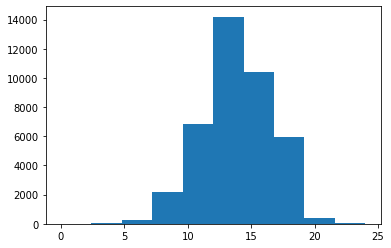

In [199]:
dff = df.dropna(subset=['fixed'])
depths = dff['fixed'].values
plt.hist(depths)

In [137]:
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'

seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

## PALS guideline

In [145]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = 3 * df['airway_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * ETT size
--------------
explained_variance_score: 0.603
mean_squared_errors: 3.097
r2_score: 0.569


In [144]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = 3 * df['old_tube_size']
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = 3 * age-based ETT size')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = 3 * age-based ETT size
--------------
explained_variance_score: 0.624
mean_squared_errors: 2.808
r2_score: 0.609


In [143]:
OLD_VAR = 'old_depth1'
# OLD_VAR = 'old_tube_size'
df[OLD_VAR] = df['age'] / 2 + 12
#df[OLD_VAR] = df['airway_tube_size'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
#df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

print('--------------')
print('old model = age / 2 + 12')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')

--------------
old model = age / 2 + 12
--------------
explained_variance_score: 0.592
mean_squared_errors: 2.977
r2_score: 0.585


In [131]:
from sklearn.metrics import mean_absolute_error

# age (일단위)
param_dict = {
                #'learning_rate': [ 0.05, 0.07, 0.1], #[0.01, 0.03, 0.05],
                'max_depth': [4, 5, 7],#[3,4,5],
                'n_estimators': [100, 200, 300],
                #'n_estimators': [100],#[25, 50, 75, 100],
                #'n_estimators': [50],
                'subsample': [0.5, 0.8], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8], #[0.8, 1],
                #'gamma': [0.9], #[0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [5, 10], #[1,10,30,100]
            }
nfold = 5
gs = RandomizedSearchCV(n_iter=100,
                        estimator=xgb.sklearn.XGBRegressor(),
                        n_jobs=-1,
                        verbose=5,
                        param_distributions=param_dict, cv=nfold)
gs.fit(x_train, y_train)
model = gs.best_estimator_.get_booster()

print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

y_pred = gs.predict(x_test).flatten()


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(y_test, y_pred):.3f}')

/home/painstudy/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits

========= found hyperparameter =========
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'colsample_bytree': 0.5}
0.7925042013962639
--------------
new model
--------------
explained_variance_score: 0.790
mean_squared_errors: 1.561
r2_score: 0.790


In [133]:
print(f'acc(+-1cm): {np.mean((y_pred >= y_test-1) & (y_pred <= y_test+1)):.3f}')

acc(+-1cm): 0.700


In [134]:
np.min(y_pred), np.max(y_pred), np.min(y_test), np.max(y_test)

(7.589564, 20.347792, 1.5, 24.0)

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals, label='GBRT')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.savefig('new.png')
plt.close()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv, math


# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 0, 'weight'] = None
df.loc[df['height'] <= 0, 'height'] = None
df['age'] = df['age'].astype(int)
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

# age, sex, airway tube size 값이 없는 경우는 제외
df.dropna(subset=['age', 'airway_tube_size'], inplace=True)
df['sex'] = (df['sex'] == 'M')

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')

# inclusion criteria : 소아 10세 미만
df = df.loc[df['age_cal'] < 10-0.01]
df = df.loc[df['age_cal'] > 0]
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

perc = np.mean(df['cuffed'].values)
print(f'소아 10세 미만에서 cuffed ETT 사용 비율: {perc:.3f}')
print(f'소아 10세 미만 최종 opid수: {len(df)}')

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: np.round((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)


# fixed depth를 output
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed', 'airway_tube_size']
TARGET_VAR = 'fixed'


random.seed(98)
#seed_everything(SEED)
df.dropna(subset=['fixed'], inplace=True)
df = df.loc[df['fixed']>=12]
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)
c = df['opid'].values.flatten().astype(int)

# 저장하기
pickle.dump(df, open(f'dataset/ETT_depth_12','wb'))
np.savez(f'dataset/ETT_depth_12.npz', x=x, y=y, c=c)


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

# Comparison of each model

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
dat = np.load(f'dataset/ETT_size.npz')
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

x_train: (27234, 5), x_test: (6808, 5)


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [28]:
# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/size/acc1-0.601_acc3-0.966_XGBR_10fold/model.model')
y_xgbr = xgbr.predict(x_test).flatten()
y_xgbr1 = np.round(y_xgbr * 2) / 2
acc3 = np.mean((y_xgbr1 >= y_test-0.5) & (y_xgbr1 <= y_test+0.5))
print(f'xgbr model acc: {np.mean(y_xgbr1==y_test):.3f}, acc(+-0.5mm): {acc3:.3f}')


# RF model
rfr = pickle.load(open(f'result/size/acc1-0.595_acc3-0.963_RF_10fold/gridSearch','rb'))
y_rfr = rfr.predict(x_test_imputed).flatten()
y_rfr1 = np.round(y_rfr * 2) / 2
acc3 = np.mean((y_rfr1 >= y_test-0.5) & (y_rfr1 <= y_test+0.5))
print(f'rf model acc: {np.mean(y_rfr1==y_test):.3f}, acc(+-0.5mm): {acc3:.3f}')

# ensemble
y_ens = (y_xgbr*3 + y_rfr*2) / 5
y_ens = np.round(y_ens * 2) / 2
acc3 = np.mean((y_ens >= y_test-0.5) & (y_ens <= y_test+0.5))
print(f'ensemble model acc: {np.mean(y_ens==y_test):.3f}, acc(+-0.5mm): {acc3:.3f}')


/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


xgbr model acc: 0.601, acc(+-0.5mm): 0.966
rf model acc: 0.595, acc(+-0.5mm): 0.963
ensemble model acc: 0.598, acc(+-0.5mm): 0.965


In [24]:
np.mean(y_xgbr==y_rbr)

0.8858695652173914

## Cole's formula (age 내림으로 수정)

In [ ]:
5 -> 5/4 + 4 = 5.25 -> 10.5 -> round down 10/2 = 5
6 -> 6/4 + 4 = 5.5 -> 11 / 2 = 5.5
7 -> 7/4 + 4 = 5.75 -> 11.5 -> 11/2=5.5

In [49]:
import math
df_cole = pd.DataFrame({'age_cal':x_test[:,0], 'cuffed':x_test[:,4]})
df_cole['age'] = df_cole['age_cal'].apply(lambda x: math.floor(x))

OLD_VAR = 'old_tube_size'
df_cole[OLD_VAR] = df_cole['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df_cole[OLD_VAR] = df_cole.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

y_old = df_cole[[OLD_VAR]].values.flatten().astype(float)
y_test_old = y_old[-ntest:]

In [50]:
print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.817
mean_squared_errors: 0.321
mean_absolute_errors: 0.449
r2_score: 0.676
acc: 0.276
acc(+-0.5mm): 0.841


In [64]:
age_mask = (x_test[:,0] >= 2)

y_test_old1 = y_test_old[age_mask]
y_test1 = y_test[age_mask]


print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test1, y_test_old1):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test1, y_test_old1):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test1, y_test_old1):.3f}')
print(f'r2_score: {r2_score(y_test1, y_test_old1):.3f}')
# accuracy
acc1 = np.mean(y_test_old1==y_test1)
acc3 = np.mean((y_test_old1 >= y_test1-0.5) & (y_test_old1 <= y_test1+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.629
mean_squared_errors: 0.352
mean_absolute_errors: 0.478
r2_score: 0.188
acc: 0.247
acc(+-0.5mm): 0.815


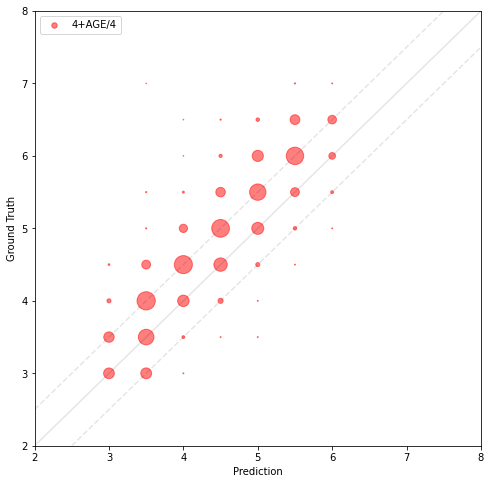

In [66]:
xvals = []
yvals = []
cvals = []
cvals_old = []
for x in np.arange(3, 8, 0.5):
    for y in np.arange(3, 8, 0.5):
        xvals.append(x)
        yvals.append(y)
        #cvals.append(sum((y_pred == x) & (y_test == y)))
        cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
#cvals = np.array(cvals) / 2
cvals_old = np.array(cvals_old) / 2

plt.figure(figsize=(8, 8))
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals_old, label='4+AGE/4')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
plt.plot([2,8], [2,8], 'k-', alpha=0.1)
plt.plot([2.5,8], [2,7.5], '--k', alpha=0.1)
plt.plot([2,7.5], [2.5,8], '--k', alpha=0.1)

In [42]:
import math

# age-based formula에 따른 ETT size
OLD_VAR = 'old_tube_size'
# df[OLD_VAR] = np.round((df['age'] / 4 + 4) * 2) / 2
df[OLD_VAR] = df['age'].apply(lambda x: math.floor((x / 4 + 4) * 2) / 2 if x >= 2 else (3.5 if x < 1 else 4)) 
df[OLD_VAR] = df.apply(lambda x: x[OLD_VAR] - 0.5 if x['cuffed'] else x[OLD_VAR], axis=1)

SEED = 98
INPUT_VARS = ['age_cal','sex','weight','height', 'cuffed']
TARGET_VAR = 'airway_tube_size'


random.seed(SEED)
df = shuffle(df)
df.reset_index(drop=True, inplace=True)
y = df[[TARGET_VAR]].values.flatten().astype(float)
c = df['opid'].values.flatten().astype(int)
y_old = df[[OLD_VAR]].values.flatten().astype(float)
x = df.loc[:, INPUT_VARS].values.astype(float)



# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]


print('--------------')
print('old model = age/4+4')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(y_test, y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(y_test, y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(y_test, y_test_old):.3f}')
print(f'r2_score: {r2_score(y_test, y_test_old):.3f}')
# accuracy
acc1 = np.mean(y_test_old==y_test)
acc3 = np.mean((y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

--------------
old model = age/4+4
--------------
explained_variance_score: 0.805
mean_squared_errors: 0.342
mean_absolute_errors: 0.459
r2_score: 0.655
acc: 0.279
acc(+-0.5mm): 0.823


# Demography

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, math
import matplotlib.pyplot as plt
import numpy as np


dat = np.load(f'dataset/ETT_size-outliers3.npz')
df = pickle.load(open('dataset/df-outliers3', 'rb'))
x, y = dat['x'], dat['y']


# training set의 뒤쪽 20%를 test set 으로 사용
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]


df_train = df.loc[:ntrain-1:]
df_test = df.loc[ntrain:]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (24764, 5), x_test: (6190, 5)


### Outliers

In [73]:
# 결측치 비율
np.mean(np.isnan(x[:,3])), np.mean(np.isnan(x[:,2]))

(0.02861171494036778, 0.01304271194406909)

In [49]:
height = x[:,3]
weight = x[:,2]

np.sum(weight>250), np.sum(height>200), np.sum(height<30), np.sum(weight<1)

(1, 2, 144, 2)

In [50]:
height[height>200], weight[height>200], height[weight>200],    # height outlier는 train, test 하나씩, weight는 train에 하나


(array([236.7, 874.2]), array([28.8, 12.7]), array([90.]), array([1301.]))

weight>250: 1(0.003%), height>200: 2(0.006%)


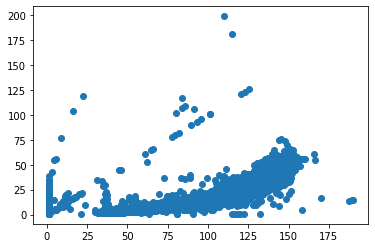

In [42]:
# outlier 제거 (invalid value)
height = x[:,3]
weight = x[:,2]

print(f'weight>250: {np.sum(weight>250)}({np.mean(weight>250)*100:.3f}%), height>200: {np.sum(height>200)}({np.mean(height>200)*100:.3f}%)') 
out_mask = (height<200) & (weight<250)
#out_mask = np.logical_and(height<200, weight<250)
#print(np.sum(~out_mask))

height = height[out_mask]
weight = weight[out_mask]

plt.scatter(height, weight)
#np.sum(height>200)
#height = height[height<200]
#np.max(height)

In [44]:
np.nanmax(x_train[:,2]), np.nanmax(x_test[:,2]), np.nanmax(x_train[:,3]), np.nanmax(x_test[:,3])

(1301.0, 123.0, 236.7, 874.2)

## Table 1

In [35]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [42]:
from scipy import stats

print(f'정규성 검사(age): train-{stats.shapiro(x_train[:,0])}, test-{stats.shapiro(x_test[:,0])}')
print(f'정규성 검사(weight): train-{stats.shapiro(x_train_imputed[:,2])}, test-{stats.shapiro(x_test_imputed[:,2])}')
print(f'정규성 검사(height): train-{stats.shapiro(x_train_imputed[:,3])}, test-{stats.shapiro(x_test_imputed[:,3])}')
print(f'정규성 검사(size): train-{stats.shapiro(y_train)}, test-{stats.shapiro(y_test)}')

정규성 검사(age): train-ShapiroResult(statistic=0.9053552150726318, pvalue=0.0), test-ShapiroResult(statistic=0.9067705869674683, pvalue=0.0)
정규성 검사(weight): train-ShapiroResult(statistic=0.9437068700790405, pvalue=0.0), test-ShapiroResult(statistic=0.9469149708747864, pvalue=1.478369879862682e-42)
정규성 검사(height): train-ShapiroResult(statistic=0.9778341054916382, pvalue=0.0), test-ShapiroResult(statistic=0.9779300689697266, pvalue=6.248798946711334e-30)
정규성 검사(size): train-ShapiroResult(statistic=0.9493086338043213, pvalue=0.0), test-ShapiroResult(statistic=0.9504018425941467, pvalue=1.697673089529516e-41)


/home/painstudy/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [41]:
stats.kstest(x_train_imputed[:,2], 'norm')

KstestResult(statistic=0.9860440529574263, pvalue=0.0)

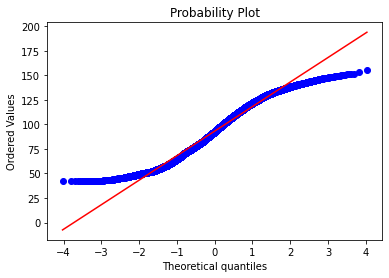

In [50]:
from scipy import stats

stats.probplot(x_train_imputed[:,3], dist=stats.norm, plot=plt)
plt.show()

(array([1426., 2518., 2988., 3711., 3455., 3316., 3269., 2548., 1392.,
         141.]),
 array([ 42.        ,  53.3100871 ,  64.62017419,  75.93026129,
         87.24034838,  98.55043548, 109.86052257, 121.17060967,
        132.48069676, 143.79078386, 155.10087096]),
 <BarContainer object of 10 artists>)

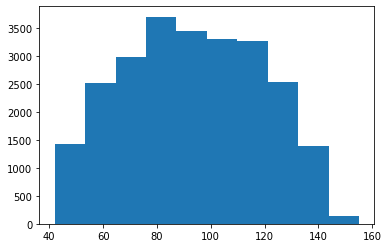

In [45]:
plt.hist(x_train_imputed[:,3])

### SD

In [12]:
print(f'total x_train: {len(x_train)}, x_test: {len(x_test)}')
# age
print(f'[age] \ntrain - mean : {np.mean(x_train[:,0]):.2f}, std : {np.std(x_train[:,0]):.2f}')
print(f'test - mean : {np.mean(x_test[:,0]):.2f}, std : {np.std(x_test[:,0]):.2f}\n')
print(f'neonate: train {np.sum(x_train[:,0]<1/12)} ({np.sum(x_train[:,0]<1/12)/len(x_train):.4f}), test {np.sum(x_test[:,0]<1/12)} ({np.sum(x_test[:,0]<1/12)/len(x_test):.4f})')
print(f'infant: train {np.sum((x_train[:,0]<1)&(x_train[:,0]>1/12))} ({np.sum((x_train[:,0]<1)&(x_train[:,0]>1/12))/len(x_train):.4f}), test {np.sum((x_test[:,0]<1)&(x_test[:,0]>1/12))} ({np.sum((x_test[:,0]<1)&(x_test[:,0]>1/12))/len(x_test):.4f})')
print(f'the others: train {np.sum(x_train[:,0]>1)} ({np.sum(x_train[:,0]>1)/len(x_train):.4f}), test {np.sum(x_test[:,0]>1)} ({np.sum(x_test[:,0]>1)/len(x_test):.4f})')


# sex
print(f'[sex] \ntrain - female : {len(x_train)-np.sum(x_train[:,1])}({1-np.mean(x_train[:,1]):.3f}), male: {np.sum(x_train[:,1])}({np.mean(x_train[:,1]):.3f})')
print(f'test - female : {len(x_test)-np.sum(x_test[:,1])}({1-np.mean(x_test[:,1]):.3f}), male: {np.sum(x_test[:,1])}({np.mean(x_test[:,1]):.3f})\n')


# weight
print(f'[weight]  mean : {np.nanmean(x_train[:,2]):.2f}, std : {np.nanstd(x_train[:,2]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,2]):.2f}, std : {np.nanstd(x_test[:,2]):.2f}\n')

# height
print(f'[height]  mean : {np.nanmean(x_train[:,3]):.2f}, std : {np.nanstd(x_train[:,3]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,3]):.2f}, std : {np.nanstd(x_test[:,3]):.2f}\n')

# cuff
print(f'[cuff] cuffed : {np.sum(x_train[:,4])}({np.mean(x_train[:,4]):.3f}), uncuffed: {len(x_train)-np.sum(x_train[:,4])}({1-np.mean(x_train[:,4]):.3f})')
print(f'test - cuffed : {np.sum(x_test[:,4])}({np.mean(x_test[:,4]):.3f}), uncuffed: {len(x_test)-np.sum(x_test[:,4])}({1-np.mean(x_test[:,4]):.3f})\n')

# tube size
print(f'[tube size] \ntrain - mean : {np.mean(y_train):.2f}, std : {np.std(y_train):.2f}')
print(f'test - mean : {np.mean(y_test):.2f}, std : {np.std(y_test):.2f}\n')

total x_train: 24764, x_test: 6190
[age] 
train - mean : 3.50, std : 2.95
test - mean : 3.47, std : 2.93

neonate: train 855 (0.0345), test 228 (0.0368)
infant: train 6035 (0.2437), test 1487 (0.2402)
the others: train 17874 (0.7218), test 4475 (0.7229)
[sex] 
train - female : 10294.0(0.416), male: 14470.0(0.584)
test - female : 2496.0(0.403), male: 3694.0(0.597)

[weight]  mean : 15.36, std : 8.71
test - mean : 15.34, std : 8.63

[height]  mean : 93.24, std : 25.31
test - mean : 93.11, std : 25.23

[cuff] cuffed : 6948.0(0.281), uncuffed: 17816.0(0.719)
test - cuffed : 1763.0(0.285), uncuffed: 4427.0(0.715)

[tube size] 
train - mean : 4.77, std : 0.98
test - mean : 4.76, std : 0.98



In [59]:
height = x[:,3]
weight = x[:,2]

x[np.where((height>175) | (height<30))[0],3] = None
x[np.where((weight>150) | (weight<1))[0],2] = None

x_train = x[:ntrain]
x_test = x[-ntest:]


# weight
print(f'[weight]  mean : {np.nanmean(x_train[:,2]):.2f}, std : {np.nanstd(x_train[:,2]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,2]):.2f}, std : {np.nanstd(x_test[:,2]):.2f}\n')

# height
print(f'[height]  mean : {np.nanmean(x_train[:,3]):.2f}, std : {np.nanstd(x_train[:,3]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,3]):.2f}, std : {np.nanstd(x_test[:,3]):.2f}\n')

[weight]  mean : 15.52, std : 9.39
test - mean : 15.47, std : 9.53

[height]  mean : 93.16, std : 25.81
test - mean : 92.79, std : 25.44



In [58]:
np.nanmax(x_train[:,2]), np.nanmax(x_test[:,2]), np.nanmax(x_train[:,3]), np.nanmax(x_test[:,3])

(199.0, 123.0, 189.9, 157.8)

In [61]:
# cuff
print(f'[cuff] cuffed : {np.sum(x_train[:,4])}({np.mean(x_train[:,4]):.3f}), uncuffed: {len(x_train)-np.sum(x_train[:,4])}({1-np.mean(x_train[:,4]):.3f})')
print(f'test - female : {np.sum(x_test[:,4])}({np.mean(x_test[:,4]):.3f}), male: {len(x_test)-np.sum(x_test[:,4])}({1-np.mean(x_test[:,4]):.3f})\n')

[cuff] cuffed : 7827.0(0.287), uncuffed: 19407.0(0.713)
test - female : 1941.0(0.285), male: 4867.0(0.715)



### IQR

In [42]:
# 정규분포를 따르지 않기에 IQR 계산 
DEMO_VARS = ['age_cal', 'weight', 'height', 'airway_tube_size']

for var in DEMO_VARS:
    #print(f'[{var}] \ntrain - {df_train[var].quantile(.25):.3f}-{df_train[var].quantile(.75):.3f} (IQR:{df_train[var].quantile(.75)-df_train[var].quantile(.25):.3f})')
    print(f'[{var}] \ntrain - median {df_train[var].quantile(.50):.3f} (IQR:{df_train[var].quantile(.25):.3f}-{df_train[var].quantile(.75):.3f}) [range:{df_train[var].min():.3f}-{df_train[var].max():.3f}]')
    #print(f'test - {df_test[var].quantile(.25):.3f}-{df_test[var].quantile(.75):.3f} (IQR:{df_test[var].quantile(.75)-df_test[var].quantile(.25):.3f})\n')
    print(f'test - median {df_test[var].quantile(.50):.3f} (IQR:{df_test[var].quantile(.25):.3f}-{df_test[var].quantile(.75):.3f}) [range:{df_test[var].min():.3f}-{df_test[var].max():.3f}]\n')

[age_cal] 
train - median 2.705 (IQR:0.860-5.793) [range:0.003-9.988]
test - median 2.719 (IQR:0.879-5.760) [range:0.003-9.988]

[weight] 
train - median 13.700 (IQR:9.100-20.200) [range:1.630-51.050]
test - median 13.800 (IQR:9.143-20.250) [range:1.710-50.800]

[height] 
train - median 92.800 (IQR:73.700-113.600) [range:42.000-151.100]
test - median 92.900 (IQR:73.800-113.225) [range:42.000-150.200]

[airway_tube_size] 
train - median 5.000 (IQR:4.000-5.500) [range:3.000-6.500]
test - median 4.500 (IQR:4.000-5.500) [range:3.000-6.500]



## 연령 구간별 demo

## Sex 별 demo

In [77]:
print(f'total x_train: {len(x_train)}, x_test: {len(x_test)}')
m_mask = (x[:,1]==1)
f_mask = (x[:,1]==0)

# age
print(f'[age] \ntrain - (male) mean : {np.mean(x[m_mask,0]):.2f}, std : {np.std(x[m_mask,0]):.2f}\t\n(female) mean : {np.mean(x[f_mask,0]):.2f}, std: {np.std(x[f_mask,0]):.2f}')

total x_train: 27234, x_test: 6808
[age] 
train - (male) mean : 3.43, std : 2.93	
(female) mean : 3.60, std: 2.97


In [ ]:
print(f'total x_train: {len(x_train)}, x_test: {len(x_test)}')
m_mask = (x[:,1]==1)
f_mask = (x[:,1]==0)

# age
print(f'[age] \ntrain - (male) mean : {np.mean(x_train[m_mask,0]):.2f}, (female) mean : {np.mean(x_train[f_mask,0]):.2f}')
print(f'test - mean : {np.mean(x_test[:,0]):.2f}, std : {np.std(x_test[:,0]):.2f}\n')

# sex
print(f'[sex] \ntrain - female : {len(x_train)-np.sum(x_train[:,1])}({1-np.mean(x_train[:,1]):.3f}), male: {np.sum(x_train[:,1])}({np.mean(x_train[:,1]):.3f})')
print(f'test - female : {len(x_test)-np.sum(x_test[:,1])}({1-np.mean(x_test[:,1]):.3f}), male: {np.sum(x_test[:,1])}({np.mean(x_test[:,1]):.3f})\n')


# weight
print(f'[weight]  mean : {np.nanmean(x_train[:,2]):.2f}, std : {np.nanstd(x_train[:,2]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,2]):.2f}, std : {np.nanstd(x_test[:,2]):.2f}\n')

# height
print(f'[height]  mean : {np.nanmean(x_train[:,3]):.2f}, std : {np.nanstd(x_train[:,3]):.2f}')
print(f'test - mean : {np.nanmean(x_test[:,3]):.2f}, std : {np.nanstd(x_test[:,3]):.2f}\n')

# cuff
print(f'[cuff] cuffed : {np.sum(x_train[:,4])}({np.mean(x_train[:,4]):.3f}), uncuffed: {len(x_train)-np.sum(x_train[:,4])}({1-np.mean(x_train[:,4]):.3f})')
print(f'test - female : {np.sum(x_test[:,4])}({1-np.mean(x_test[:,4]):.3f}), male: {len(x_test)-np.sum(x_test[:,4])}({len(x_test)-np.mean(x_test[:,4]):.3f})\n')

# tube size
print(f'[tube size] \ntrain - mean : {np.mean(y_train):.2f}, std : {np.std(y_train):.2f}')
print(f'test - mean : {np.mean(y_test):.2f}, std : {np.std(y_test):.2f}\n')

### Imputation 확인

In [78]:
df_train

,0,1,2,3,4
0,6.765368,0.0,20.65,116.0,0.0
1,1.582510,1.0,10.20,82.0,1.0
2,7.263667,0.0,24.15,121.5,1.0
3,1.056832,0.0,9.80,73.7,1.0
4,4.438147,0.0,19.90,99.0,0.0
...,...,...,...,...,...
27229,5.774246,1.0,24.75,118.6,0.0
27230,0.309383,1.0,4.20,49.7,1.0
27231,1.451091,1.0,9.70,83.9,1.0
27232,1.273127,1.0,14.00,90.0,0.0


In [84]:
df_train.loc[114]

0     6.987139
1     0.000000
2    28.000000
3          NaN
4     0.000000
Name: 114, dtype: float64

In [83]:
df_train = pd.DataFrame(x_train)
df_train[3].isnull().tolist().index(1)

114

In [85]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

In [86]:
df_train_imp = pd.DataFrame(x_train_imputed)
df_train_imp.loc[114]

0      6.987139
1      0.000000
2     28.000000
3    121.907880
4      0.000000
Name: 114, dtype: float64

## tube size 별 %

In [14]:
print(f'tube < 3 n_samples (%): {np.sum(y_train<3)}({np.mean(y_train<3)*100:.2f})')
print(f'tube 3.0 n_samples (%): {np.sum(y_train==3)}({np.mean(y_train==3)*100:.2f})')
print(f'tube 3.5 n_samples (%): {np.sum(y_train==3.5)}({np.mean(y_train==3.5)*100:.2f})')
print(f'tube 4.0 n_samples (%): {np.sum(y_train==4)}({np.mean(y_train==4)*100:.2f})')
print(f'tube 4.5 n_samples (%): {np.sum(y_train==4.5)}({np.mean(y_train==4.5)*100:.2f})')
print(f'tube 5.0 n_samples (%): {np.sum(y_train==5)}({np.mean(y_train==5)*100:.2f})')
print(f'tube 5.5 n_samples (%): {np.sum(y_train==5.5)}({np.mean(y_train==5.5)*100:.2f})')
print(f'tube 6.0 n_samples (%): {np.sum(y_train==6)}({np.mean(y_train==6)*100:.2f})')
print(f'tube >6 n_samples (%): {np.sum(y_train>6)}({np.mean(y_train>6)*100:.2f})')

tube < 3 n_samples (%): 0(0.00)
tube 3.0 n_samples (%): 1751(7.07)
tube 3.5 n_samples (%): 2655(10.72)
tube 4.0 n_samples (%): 3641(14.70)
tube 4.5 n_samples (%): 4303(17.38)
tube 5.0 n_samples (%): 3877(15.66)
tube 5.5 n_samples (%): 3408(13.76)
tube 6.0 n_samples (%): 3788(15.30)
tube >6 n_samples (%): 1341(5.42)


In [17]:
print(f'tube < 3 n_samples (%): {np.sum(y_test<3)}({np.mean(y_test<3)*100:.2f})')
print(f'tube 3.0 n_samples (%): {np.sum(y_test==3)}({np.mean(y_test==3)*100:.2f})')
print(f'tube 3.5 n_samples (%): {np.sum(y_test==3.5)}({np.mean(y_test==3.5)*100:.2f})')
print(f'tube 4.0 n_samples (%): {np.sum(y_test==4)}({np.mean(y_test==4)*100:.2f})')
print(f'tube 4.5 n_samples (%): {np.sum(y_test==4.5)}({np.mean(y_test==4.5)*100:.2f})')
print(f'tube 5.0 n_samples (%): {np.sum(y_test==5)}({np.mean(y_test==5)*100:.2f})')
print(f'tube 5.5 n_samples (%): {np.sum(y_test==5.5)}({np.mean(y_test==5.5)*100:.2f})')
print(f'tube 6.0 n_samples (%): {np.sum(y_test==6)}({np.mean(y_test==6)*100:.2f})')
print(f'tube >6 n_samples (%): {np.sum(y_test>6)}({np.mean(y_test>6)*100:.2f})')

tube < 3 n_samples (%): 0(0.00)
tube 3.0 n_samples (%): 443(7.16)
tube 3.5 n_samples (%): 667(10.78)
tube 4.0 n_samples (%): 892(14.41)
tube 4.5 n_samples (%): 1094(17.67)
tube 5.0 n_samples (%): 988(15.96)
tube 5.5 n_samples (%): 883(14.26)
tube 6.0 n_samples (%): 917(14.81)
tube >6 n_samples (%): 306(4.94)


In [81]:
cmask = x_train[:,4]==1

print(f'tube < 3 n_samples (%): {np.sum(y_train[cmask]<3)}({np.sum(y_train[cmask]<3)*100/len(y_train):.2f})')
print(f'tube 3.0 n_samples (%): {np.sum(y_train[cmask]==3)}({np.sum(y_train[cmask]==3)*100/len(y_train):.2f})')
print(f'tube 3.5 n_samples (%): {np.sum(y_train[cmask]==3.5)}({np.sum(y_train[cmask]==3.5)*100/len(y_train):.2f})')
print(f'tube 4.0 n_samples (%): {np.sum(y_train[cmask]==4)}({np.sum(y_train[cmask]==4)*100/len(y_train):.2f})')
print(f'tube 4.5 n_samples (%): {np.sum(y_train[cmask]==4.5)}({np.sum(y_train[cmask]==4.5)*100/len(y_train):.2f})')
print(f'tube 5.0 n_samples (%): {np.sum(y_train[cmask]==5)}({np.sum(y_train[cmask]==5)*100/len(y_train):.2f})')
print(f'tube 5.5 n_samples (%): {np.sum(y_train[cmask]==5.5)}({np.sum(y_train[cmask]==5.5)*100/len(y_train):.2f})')
print(f'tube 6.0 n_samples (%): {np.sum(y_train[cmask]==6)}({np.sum(y_train[cmask]==6)*100/len(y_train):.2f})')
print(f'tube >6 n_samples (%): {np.sum(y_train[cmask]>6)}({np.sum(y_train[cmask]>6)*100/len(y_train):.2f})\n\n')

print(f'tube < 3 n_samples (%): {np.sum(y_train[~cmask]<3)}({np.sum(y_train[~cmask]<3)*100/len(y_train):.2f})')
print(f'tube 3.0 n_samples (%): {np.sum(y_train[~cmask]==3)}({np.sum(y_train[~cmask]==3)*100/len(y_train):.2f})')
print(f'tube 3.5 n_samples (%): {np.sum(y_train[~cmask]==3.5)}({np.sum(y_train[~cmask]==3.5)*100/len(y_train):.2f})')
print(f'tube 4.0 n_samples (%): {np.sum(y_train[~cmask]==4)}({np.sum(y_train[~cmask]==4)*100/len(y_train):.2f})')
print(f'tube 4.5 n_samples (%): {np.sum(y_train[~cmask]==4.5)}({np.sum(y_train[~cmask]==4.5)*100/len(y_train):.2f})')
print(f'tube 5.0 n_samples (%): {np.sum(y_train[~cmask]==5)}({np.sum(y_train[~cmask]==5)*100/len(y_train):.2f})')
print(f'tube 5.5 n_samples (%): {np.sum(y_train[~cmask]==5.5)}({np.sum(y_train[~cmask]==5.5)*100/len(y_train):.2f})')
print(f'tube 6.0 n_samples (%): {np.sum(y_train[~cmask]==6)}({np.sum(y_train[~cmask]==6)*100/len(y_train):.2f})')
print(f'tube >6 n_samples (%): {np.sum(y_train[~cmask]>6)}({np.sum(y_train[~cmask]>6)*100/len(y_train):.2f})')

tube < 3 n_samples (%): 0(0.00)
tube 3.0 n_samples (%): 902(3.64)
tube 3.5 n_samples (%): 868(3.51)
tube 4.0 n_samples (%): 925(3.74)
tube 4.5 n_samples (%): 908(3.67)
tube 5.0 n_samples (%): 872(3.52)
tube 5.5 n_samples (%): 892(3.60)
tube 6.0 n_samples (%): 1392(5.62)
tube >6 n_samples (%): 189(0.76)


tube < 3 n_samples (%): 0(0.00)
tube 3.0 n_samples (%): 849(3.43)
tube 3.5 n_samples (%): 1787(7.22)
tube 4.0 n_samples (%): 2716(10.97)
tube 4.5 n_samples (%): 3395(13.71)
tube 5.0 n_samples (%): 3005(12.13)
tube 5.5 n_samples (%): 2516(10.16)
tube 6.0 n_samples (%): 2396(9.68)
tube >6 n_samples (%): 1152(4.65)


In [82]:
cmask = x_test[:,4]==1

print(f'tube < 3 n_samples (%): {np.sum(y_test[cmask]<3)}({np.sum(y_test[cmask]<3)*100/len(y_test):.2f})')
print(f'tube 3.0 n_samples (%): {np.sum(y_test[cmask]==3)}({np.sum(y_test[cmask]==3)*100/len(y_test):.2f})')
print(f'tube 3.5 n_samples (%): {np.sum(y_test[cmask]==3.5)}({np.sum(y_test[cmask]==3.5)*100/len(y_test):.2f})')
print(f'tube 4.0 n_samples (%): {np.sum(y_test[cmask]==4)}({np.sum(y_test[cmask]==4)*100/len(y_test):.2f})')
print(f'tube 4.5 n_samples (%): {np.sum(y_test[cmask]==4.5)}({np.sum(y_test[cmask]==4.5)*100/len(y_test):.2f})')
print(f'tube 5.0 n_samples (%): {np.sum(y_test[cmask]==5)}({np.sum(y_test[cmask]==5)*100/len(y_test):.2f})')
print(f'tube 5.5 n_samples (%): {np.sum(y_test[cmask]==5.5)}({np.sum(y_test[cmask]==5.5)*100/len(y_test):.2f})')
print(f'tube 6.0 n_samples (%): {np.sum(y_test[cmask]==6)}({np.sum(y_test[cmask]==6)*100/len(y_test):.2f})')
print(f'tube >6 n_samples (%): {np.sum(y_test[cmask]>6)}({np.sum(y_test[cmask]>6)*100/len(y_test):.2f})\n\n')

print(f'tube < 3 n_samples (%): {np.sum(y_test[~cmask]<3)}({np.sum(y_test[~cmask]<3)*100/len(y_test):.2f})')
print(f'tube 3.0 n_samples (%): {np.sum(y_test[~cmask]==3)}({np.sum(y_test[~cmask]==3)*100/len(y_test):.2f})')
print(f'tube 3.5 n_samples (%): {np.sum(y_test[~cmask]==3.5)}({np.sum(y_test[~cmask]==3.5)*100/len(y_test):.2f})')
print(f'tube 4.0 n_samples (%): {np.sum(y_test[~cmask]==4)}({np.sum(y_test[~cmask]==4)*100/len(y_test):.2f})')
print(f'tube 4.5 n_samples (%): {np.sum(y_test[~cmask]==4.5)}({np.sum(y_test[~cmask]==4.5)*100/len(y_test):.2f})')
print(f'tube 5.0 n_samples (%): {np.sum(y_test[~cmask]==5)}({np.sum(y_test[~cmask]==5)*100/len(y_test):.2f})')
print(f'tube 5.5 n_samples (%): {np.sum(y_test[~cmask]==5.5)}({np.sum(y_test[~cmask]==5.5)*100/len(y_test):.2f})')
print(f'tube 6.0 n_samples (%): {np.sum(y_test[~cmask]==6)}({np.sum(y_test[~cmask]==6)*100/len(y_test):.2f})')
print(f'tube >6 n_samples (%): {np.sum(y_test[~cmask]>6)}({np.sum(y_test[~cmask]>6)*100/len(y_test):.2f})')

tube < 3 n_samples (%): 0(0.00)
tube 3.0 n_samples (%): 209(3.38)
tube 3.5 n_samples (%): 238(3.84)
tube 4.0 n_samples (%): 228(3.68)
tube 4.5 n_samples (%): 258(4.17)
tube 5.0 n_samples (%): 220(3.55)
tube 5.5 n_samples (%): 229(3.70)
tube 6.0 n_samples (%): 334(5.40)
tube >6 n_samples (%): 47(0.76)


tube < 3 n_samples (%): 0(0.00)
tube 3.0 n_samples (%): 234(3.78)
tube 3.5 n_samples (%): 429(6.93)
tube 4.0 n_samples (%): 664(10.73)
tube 4.5 n_samples (%): 836(13.51)
tube 5.0 n_samples (%): 768(12.41)
tube 5.5 n_samples (%): 654(10.57)
tube 6.0 n_samples (%): 583(9.42)
tube >6 n_samples (%): 259(4.18)


In [97]:
print(f'tube 2.0 n_samples (%): {np.sum(y_test==2)}({np.mean(y_test==2)*100:.2f})')
print(f'tube 2.5 n_samples (%): {np.sum(y_test==2.5)}({np.mean(y_test==2.5)*100:.2f})')
print(f'tube 3.0 n_samples (%): {np.sum(y_test==3)}({np.mean(y_test==3)*100:.2f})')
print(f'tube 3.5 n_samples (%): {np.sum(y_test==3.5)}({np.mean(y_test==3.5)*100:.2f})')
print(f'tube 4.0 n_samples (%): {np.sum(y_test==4)}({np.mean(y_test==4)*100:.2f})')
print(f'tube 4.5 n_samples (%): {np.sum(y_test==4.5)}({np.mean(y_test==4.5)*100:.2f})')
print(f'tube 5.0 n_samples (%): {np.sum(y_test==5)}({np.mean(y_test==5)*100:.2f})')
print(f'tube 5.5 n_samples (%): {np.sum(y_test==5.5)}({np.mean(y_test==5.5)*100:.2f})')
print(f'tube 6.0 n_samples (%): {np.sum(y_test==6)}({np.mean(y_test==6)*100:.2f})')
print(f'tube 6.5 n_samples (%): {np.sum(y_test==6.5)}({np.mean(y_test==6.5)*100:.2f})')
print(f'tube 7.0 n_samples (%): {np.sum(y_test==7)}({np.mean(y_test==7)*100:.2f})')
print(f'tube 7.5 n_samples (%): {np.sum(y_test==7.5)}({np.mean(y_test==7.5)*100:.2f})')
print(f'tube 8.0 n_samples (%): {np.sum(y_test==8)}({np.mean(y_test==8)*100:.2f})')
print(f'tube 8.5 n_samples (%): {np.sum(y_test==8.5)}({np.mean(y_test==8.5)*100:.2f})')

tube 2.0 n_samples (%): 6(0.09)
tube 2.5 n_samples (%): 40(0.59)
tube 3.0 n_samples (%): 471(6.92)
tube 3.5 n_samples (%): 726(10.66)
tube 4.0 n_samples (%): 1021(15.00)
tube 4.5 n_samples (%): 1207(17.73)
tube 5.0 n_samples (%): 1085(15.94)
tube 5.5 n_samples (%): 904(13.28)
tube 6.0 n_samples (%): 972(14.28)
tube 6.5 n_samples (%): 370(5.43)
tube 7.0 n_samples (%): 6(0.09)
tube 7.5 n_samples (%): 0(0.00)
tube 8.0 n_samples (%): 0(0.00)
tube 8.5 n_samples (%): 0(0.00)


## depth

In [43]:
dat = np.load(f'dataset/ETT_depth-outliers.npz')
x, y = dat['x'], dat['y']
x = x[:,0:5]
df = pickle.load(open('dataset/ETT_depth-outliers', 'rb'))

nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

df_train = df.loc[:ntrain-1:]
df_test = df.loc[ntrain:]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (21344, 5), x_test: (5335, 5)


In [31]:
from scipy import stats
stats.shapiro(df_train['fixed'].values)

/home/painstudy/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9799808263778687, pvalue=0.0)

In [33]:
from scipy import stats

depth_train = df_train['fixed'].values
depth_test = df_test['fixed'].values
print(f'정규성 검사(size): train-{stats.shapiro(depth_train)}, test-{stats.shapiro(depth_test)}')

정규성 검사(size): train-ShapiroResult(statistic=0.9799808263778687, pvalue=0.0), test-ShapiroResult(statistic=0.9795219302177429, pvalue=4.5403613549654424e-27)


In [19]:
# tube size
print(f'[tube depth] \ntrain - mean : {np.mean(y_train):.2f}, std : {np.std(y_train):.2f}')
print(f'test - mean : {np.mean(y_test):.2f}, std : {np.std(y_test):.2f}\n')

[tube depth] 
train - mean : 13.72, std : 2.60
test - mean : 13.69, std : 2.58



In [44]:
# 정규분포를 따르지 않기에 IQR 계산 
DEMO_VARS = ['fixed']

for var in DEMO_VARS:
    #print(f'[{var}] \ntrain - {df_train[var].quantile(.25):.3f}-{df_train[var].quantile(.75):.3f} (IQR:{df_train[var].quantile(.75)-df_train[var].quantile(.25):.3f})')
    print(f'[{var}] \ntrain - median {df_train[var].quantile(.50):.3f} (IQR:{df_train[var].quantile(.25):.3f}-{df_train[var].quantile(.75):.3f}) [range:{df_train[var].min():.3f}-{df_train[var].max():.3f}]')
    #print(f'test - {df_test[var].quantile(.25):.3f}-{df_test[var].quantile(.75):.3f} (IQR:{df_test[var].quantile(.75)-df_test[var].quantile(.25):.3f})\n')
    print(f'test - median {df_test[var].quantile(.50):.3f} (IQR:{df_test[var].quantile(.25):.3f}-{df_test[var].quantile(.75):.3f}) [range:{df_train[var].min():.3f}-{df_train[var].max():.3f}]\n')

[fixed] 
train - median 14.000 (IQR:12.000-16.000) [range:8.000-20.000]
test - median 14.000 (IQR:12.000-16.000) [range:8.000-20.000]



# Size - input correlation

## Spearman

In [123]:
height

array([ 94.3, 116.4,  82.5, ...,  77.2,  98.2, 120. ])

In [129]:
height[height<30]

array([ 6.7 , 21.  ,  1.  ,  2.2 ,  4.55,  8.8 ,  1.  ,  1.  ,  1.  ,
        1.  , 12.2 ,  1.  ,  9.5 ,  1.  ,  4.9 , 10.1 ,  1.  ,  1.  ,
        1.  ,  1.  , 13.4 , 13.  ,  9.6 ,  1.  , 17.55,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ])

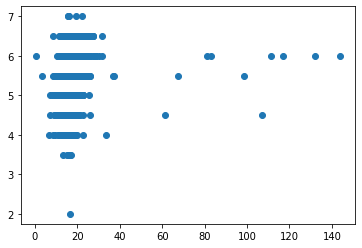

In [165]:
age = x_test_imputed[:,0]
height, weight = x_test_imputed[:,3], x_test_imputed[:,2]
mask = np.logical_and(np.logical_and(height<200, height>30), age>2)

weight = weight[mask]
height = height[mask]


bmi = weight / (height/100) / (height/100)

plt.scatter(bmi, y_test[mask])

In [104]:
x_test[:,0]

array([2.74612073, 6.91047729, 1.72488141, ..., 1.42644955, 3.50452097,
       5.9001896 ])

In [107]:
import scipy.stats as stats

rho, pval = stats.pearsonr(x_test[:,0], y_test)
rho, pval

(0.8723924366319188, 0.0)

(array([   6.,   40.,  471.,  726., 1021., 1207., 1085.,  904.,  972.,
         376.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <BarContainer object of 10 artists>)

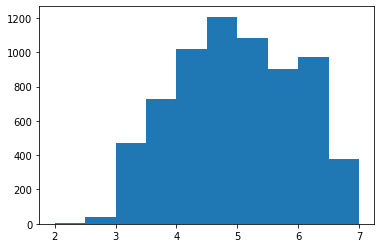

In [166]:
plt.hist(y_test)

In [82]:
import scipy.stats as stats
stats.pearsonr(x_test[:,0], y_test)

(0.8723924366319188, 0.0)

In [81]:
import scipy.stats as stats
stats.pearsonr(x_test[:,1], y_test)

(-0.0100779619100062, 0.405743655645806)

In [84]:
import scipy.stats as stats
stats.pearsonr(x_test_imputed[:,2], y_test)

(0.7946105737089508, 0.0)

In [85]:
import scipy.stats as stats
stats.pearsonr(x_test_imputed[:,3], y_test)

(0.8197764526370859, 0.0)

In [86]:
import scipy.stats as stats
stats.pearsonr(x_test[:,4], y_test)

(-0.059154626667131574, 1.0381533516208097e-06)

In [89]:
import scipy.stats as stats
stats.spearmanr(x_test[:,1], y_test)

SpearmanrResult(correlation=-0.01249872268809375, pvalue=0.30248076059007767)

# [Linearity test for age - tube size](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)

In [68]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt
import numpy as np


dat = np.load(f'dataset/ETT_size_2308.npz')
#df = pickle.load(open('dataset/df-outliers3', 'rb'))
x, y = dat['x'], dat['y']
#y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용 (이미 shuffle된 상태)
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (29646, 5), x_test: (7411, 5)


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

cmask = x_train[:,4]==1
X_train = x_train[cmask]

linear_x, linear_y = x_train[:,0].reshape(-1,1), y_train

linear_model = LinearRegression()
linear_model.fit(linear_x, linear_y)

# Returning the R^2 for the model
linear_r2 = linear_model.score(linear_x, linear_y)
print('R^2: {0}'.format(linear_r2))

def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

R^2: 0.7865834285936453


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


/home/painstudy/.local/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


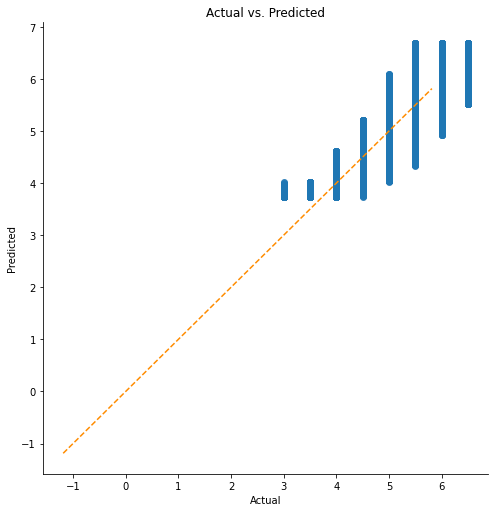

In [66]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
    
linear_assumption(linear_model, linear_x, linear_y)

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.335066045847
Residuals are normally distributed

In [91]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    #plt.subplots(figsize=(24, 12))
    #plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.savefig("Fig2_size_uncuffed.png", dpi=600)
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')
    

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/home/painstudy/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


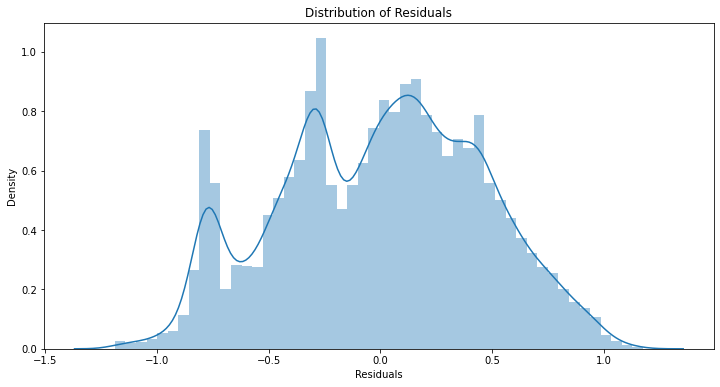


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [67]:
normal_errors_assumption(linear_model, linear_x, linear_y)

### Fig 2 (a) uncuffed ETT size - age

In [69]:
# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

In [73]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

cmask = x_train[:,3]==1
MODE = 'cuffed'
X_train = x_train_imputed[cmask]
Y_train = y_train[cmask]

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linear_x, linear_y = X_train[:,0].reshape(-1,1), Y_train

linear_model = LinearRegression()
linear_model.fit(linear_x, linear_y)

LinearRegression()

In [54]:
def plot_settings(SMALL_SIZE=18, MEDIUM_SIZE=18, BIGGER_SIZE=18, FONT_NAME='Avenir Next LT Pro'):
    plt.rc('figure', figsize=(12,12))
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # finding font
    import matplotlib.font_manager as fm
    font_path = fm.findfont(fm.FontProperties(family=FONT_NAME))
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()

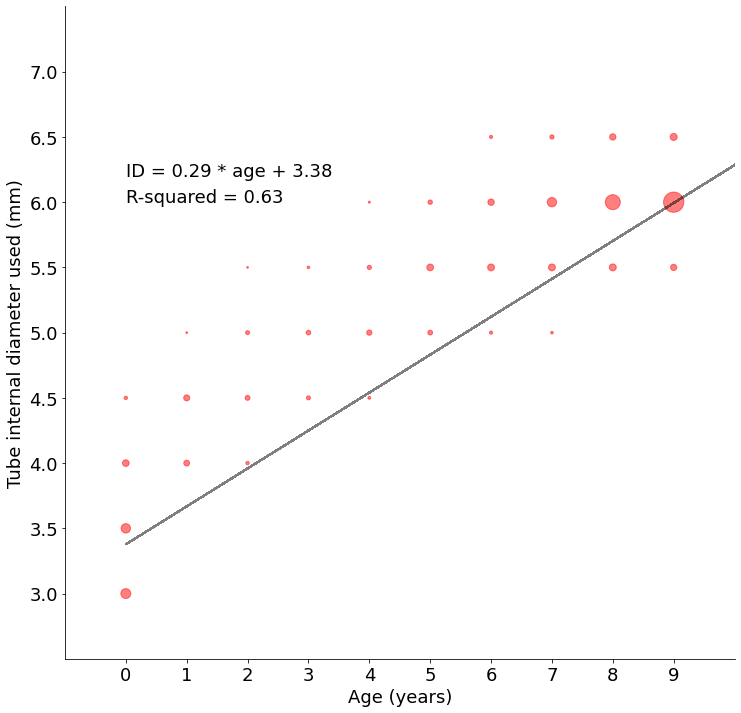

In [74]:
xvals = []
yvals = []
cvals = []
x_age = np.array([math.floor(x) for x in X_train[:,0]])

#y_fitted = linear_model.predict(np.reshape([0,9],[-1,1]))
y_fitted = linear_model.predict(X_train[:,0].reshape([-1,1]))

for x in np.arange(0, 10, 1):
    for y in np.arange(2.5, 8.0, 0.5):
        xvals.append(x)
        yvals.append(y)        
        cvals.append(sum((x_age == x) & (Y_train == y)))

xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2


# plot settings
plot_settings()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

# Remove plot frames
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_yticks([f'{y:.1f}' for y in np.arange(2.5,7.5,0.5)])
#plt.gca().set_yticklabels([f'{y:.1f}' for y in np.arange(2.5,7.5,0.5)])


plt.xticks(np.arange(0,10))
plt.yticks(np.arange(3, 7.5, 0.5), [f'{y:.1f}' for y in np.arange(3,7.5,0.5)] )
plt.xlim(-1, 10)
plt.ylim(2.5, 7.5)

plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Age (years)')
plt.ylabel(f'Tube internal diameter used (mm)')
#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
#plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)
#plt.plot([-2, 10], [3.13, 7.05], 'k-', alpha = 0.5)
plt.plot(x_age, linear_model.predict(x_age.reshape([-1,1])), 'k-', alpha = 0.5)

equation = f'ID = {linear_model.coef_[0]:.2f} * age + {linear_model.intercept_:.2f}'
r_squared = f'R-squared = {r2_score(Y_train,y_fitted):.2f}'
plt.text(0, 6.2, equation, fontsize=18)
plt.text(0, 6, r_squared, fontsize=18)

plt.savefig(f"figures/Fig3_c_{MODE}_scatter.png", dpi=600)

### Fig 2 (b) cuffed ETT size residual plot

/home/painstudy/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


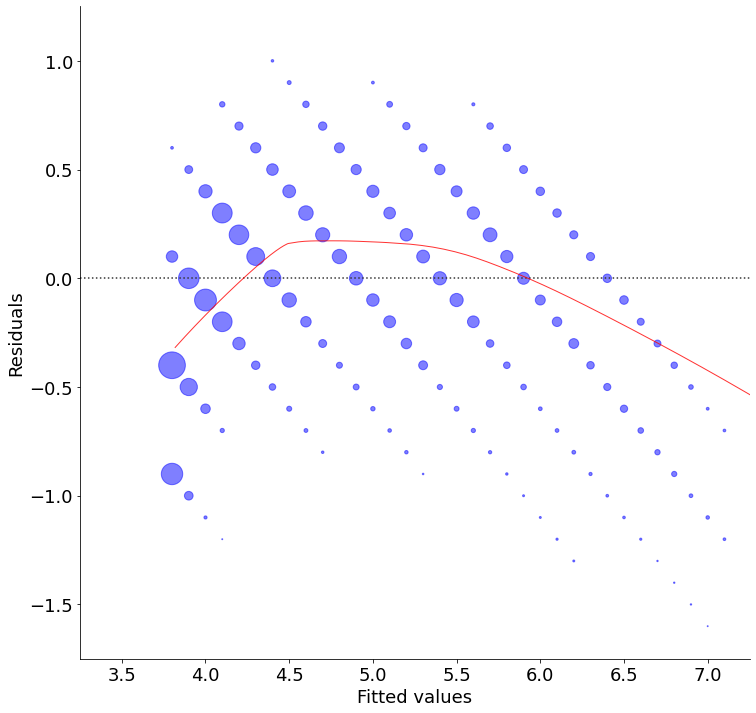

In [72]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot


df_m = pd.DataFrame({'X':X_train[:,0], 'Y':Y_train})

# generate OLS model
#model_fit = sm.OLS(pd.DataFrame({'Y':Y_train}), sm.add_constant(df_m)).fit()
model_fit = sm.OLS(pd.DataFrame({'Y':Y_train}), sm.add_constant(X_train[:,0])).fit()


# model values
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# density for residuals - fitted plot
X = model_fitted_y
Y = model_residuals

xvals = []
yvals = []
cvals = []
cuff_mask = (x_train[:,3]==1)

for x in np.arange(2.8, 7.2, 0.1):
    for y in np.arange(-1.6, 1.1, 0.1):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((X >= x) & (X < x + 0.1) & (Y >= y) & (Y < y + 0.1)))

xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2


# plot setting
UPPER_FIT = 7.0
LOWER_FIT = 3.5
UPPER_RES = 1.0
LOWER_RES = -1.5

plot_settings()
plot_lm_1 = plt.figure(figsize=(12,12))
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, df_m.columns[-1], data=df_m,
                          lowess=True,
                          scatter_kws={'alpha': 0},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})


# Remove plot frames
plot_lm_1.axes[0].spines['top'].set_visible(False)
plot_lm_1.axes[0].spines['right'].set_visible(False)

#plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
plot_lm_1.axes[0].set_xlim(LOWER_FIT-0.25, UPPER_FIT+0.25)
plot_lm_1.axes[0].set_ylim(LOWER_RES-0.25, UPPER_RES+0.25)
plot_lm_1.axes[0].set_xticks(np.arange(LOWER_FIT, UPPER_FIT+0.5, 0.5), [f'{y:.1f}' for y in np.arange(LOWER_FIT, UPPER_FIT+0.5,0.5)])
plot_lm_1.axes[0].set_yticks(np.arange(LOWER_RES,UPPER_RES+0.5,0.5))

plot_lm_1.axes[0] = plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals)
plt.savefig(f"figures/Fig3_b_{MODE}_residuals.png", dpi=600)

/home/painstudy/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


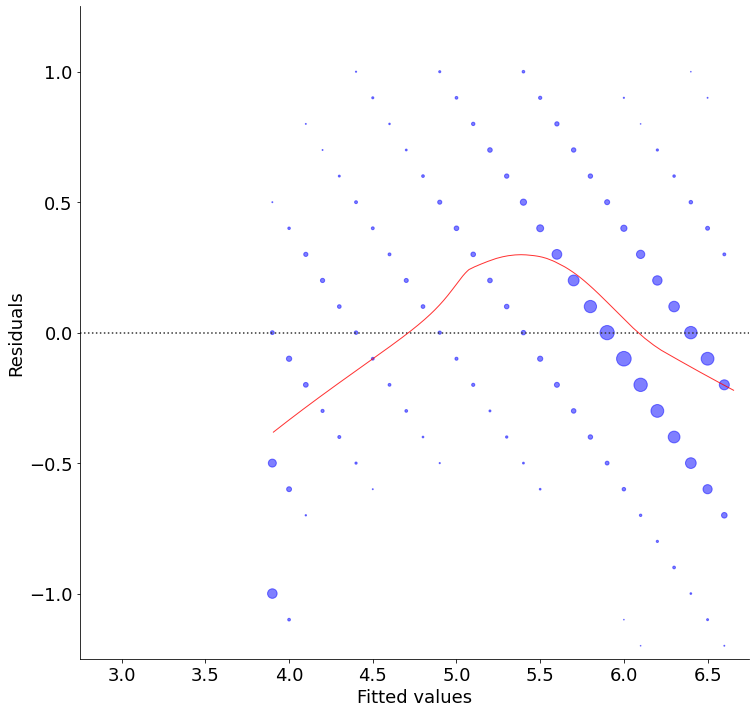

In [75]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot


df_m = pd.DataFrame({'X':X_train[:,0], 'Y':Y_train})

# generate OLS model
#model_fit = sm.OLS(pd.DataFrame({'Y':Y_train}), sm.add_constant(df_m)).fit()
model_fit = sm.OLS(pd.DataFrame({'Y':Y_train}), sm.add_constant(X_train[:,0])).fit()


# model values
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# density for residuals - fitted plot
X = model_fitted_y
Y = model_residuals

xvals = []
yvals = []
cvals = []
cuff_mask = (x_train[:,3]==0)

for x in np.arange(2.8, 7.2, 0.1):
    for y in np.arange(-1.6, 1.1, 0.1):
        xvals.append(x)
        yvals.append(y)
        cvals.append(sum((X >= x) & (X < x + 0.1) & (Y >= y) & (Y < y + 0.1)))

xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2


# plot setting
UPPER_FIT = 6.5
LOWER_FIT = 3.0
UPPER_RES = 1.0
LOWER_RES = -1.0

plot_settings()
plot_lm_1 = plt.figure(figsize=(12,12))
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, df_m.columns[-1], data=df_m,
                          lowess=True,
                          scatter_kws={'alpha': 0},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})


# Remove plot frames
plot_lm_1.axes[0].spines['top'].set_visible(False)
plot_lm_1.axes[0].spines['right'].set_visible(False)

#plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
plot_lm_1.axes[0].set_xlim(LOWER_FIT-0.25, UPPER_FIT+0.25)
plot_lm_1.axes[0].set_ylim(LOWER_RES-0.25, UPPER_RES+0.25)
plot_lm_1.axes[0].set_xticks(np.arange(LOWER_FIT, UPPER_FIT+0.5, 0.5), [f'{y:.1f}' for y in np.arange(LOWER_FIT, UPPER_FIT+0.5,0.5)])
plot_lm_1.axes[0].set_yticks(np.arange(LOWER_RES,UPPER_RES+0.5,0.5))

plot_lm_1.axes[0] = plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals)
plt.savefig(f"figures/Fig3_d_{MODE}_residuals.png", dpi=600)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 8.419e+04
Date:                Mon, 29 May 2023   Prob (F-statistic):               0.00
Time:                        01:47:51   Log-Likelihood:                -8747.3
No. Observations:               17816   AIC:                         1.750e+04
Df Residuals:                   17814   BIC:                         1.751e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7827      0.005    820.117      0.0

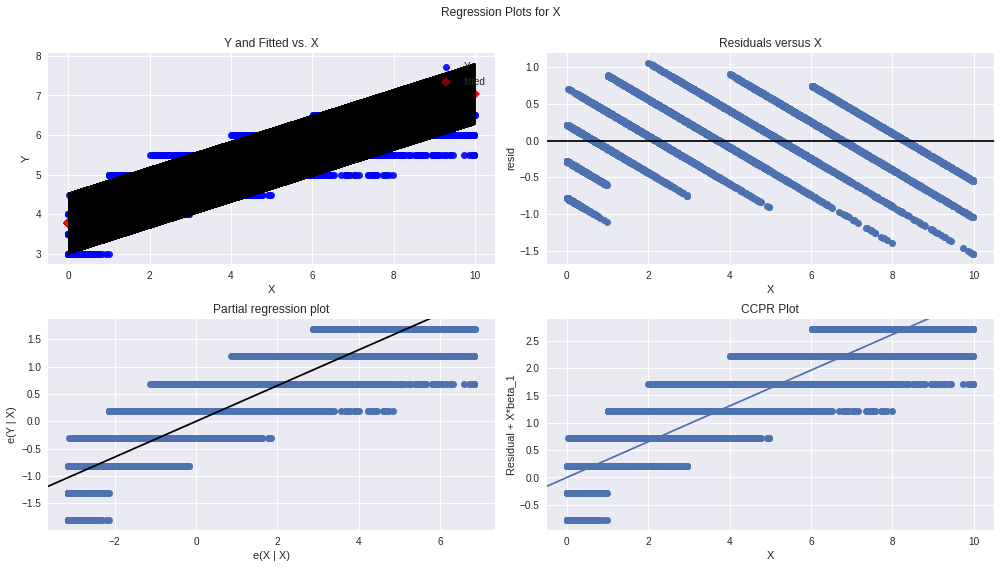

In [129]:
# display model summary
print(model_fit.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model_fit,
                                    'X',
                                    fig=fig)

* plot of residuals vs fitted for multiple linear regression model

/home/painstudy/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


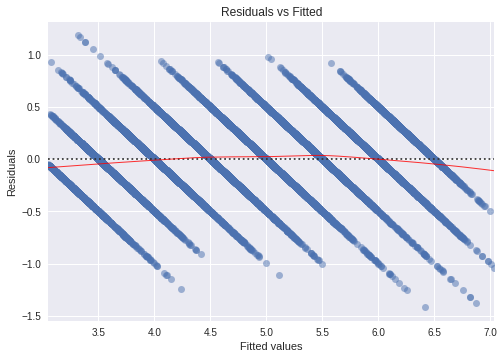

In [143]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

df_X = pd.DataFrame(X_train, columns=['age','weight', 'height', 'cuff'])
df_m = pd.concat([df_X, pd.DataFrame({'Y':Y_train})], axis = 1)
#df_m = pd.DataFrame({'X':X_train[:,0], 'Y':Y_train})

# generate OLS model
model_fit = sm.OLS(pd.DataFrame({'Y':Y_train}), sm.add_constant(df_X)).fit()


# model values
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid


plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, df_m.columns[-1], data=df_m,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [ ]:
# chat GPT 버전의 코드
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# Generate example data for simple linear regression
np.random.seed(42)
x = np.random.rand(100) * 10
y = 2 * x + np.random.randn(100)

# Fit the linear regression model
X = sm.add_constant(x)  # Add constant term to the predictor variable
model = sm.OLS(y, X)
results = model.fit()

# Calculate residuals and fitted values
residuals = results.resid
fitted_values = results.fittedvalues

# Plot residuals versus fitted values
fig, ax = plt.subplots()
ax.scatter(fitted_values, residuals, alpha=0.5)
lowess_smoothed = lowess(residuals, fitted_values)
ax.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], 'r-', linewidth=2)
ax.axhline(0, color='black', linestyle='--')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs. Fitted Values')
plt.show()

### Fig 2 (e) ETT depth - age

In [78]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt
import numpy as np


dat = np.load(f'dataset/ETT_depth_2308.npz')
df = pickle.load(open('dataset/df_depth_2308', 'rb'))
x, y = dat['x'], dat['y']
x = x[:,0:5]
#y_old = dat['y_old']


# training set의 뒤쪽 20%를 test set 으로 사용 (이미 shuffle된 상태)
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
#y_test_old = y_old[-ntest:]
y_pals = 3 * y_test_old
x_train = x[:ntrain, :]
y_train = y[:ntrain]

x_train = x_train[:,0:4]
x_test = x_test[:,0:4]

X_train, Y_train = x_train, y_train

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (25640, 4), x_test: (6410, 4)


In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linear_x, linear_y = X_train[:,0].reshape(-1,1), Y_train

linear_model = LinearRegression()
linear_model.fit(linear_x, linear_y)

LinearRegression()

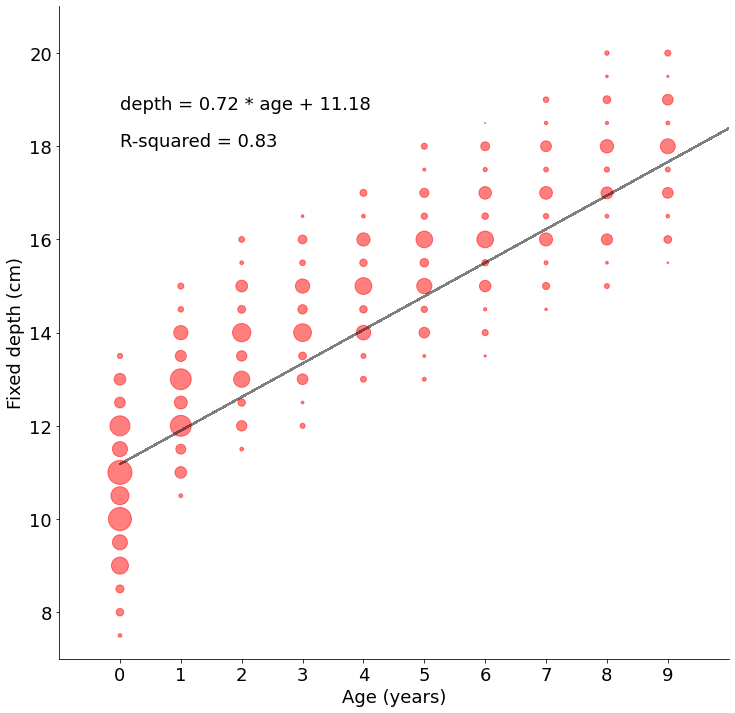

In [80]:
xvals = []
yvals = []
cvals = []
x_age = np.array([math.floor(x) for x in X_train[:,0]])

#y_fitted = linear_model.predict(np.reshape([0,9],[-1,1]))
y_fitted = linear_model.predict(X_train[:,0].reshape([-1,1]))

for x in np.arange(0, 10, 1):
    for y in np.arange(7, 21, 0.5):
        xvals.append(x)
        yvals.append(y)        
        cvals.append(sum((x_age == x) & (Y_train >= y) & (Y_train < y+ 0.5)))
                     
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2


# plot
plot_settings()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

plt.xticks(np.arange(0,10))
#plt.yticks(np.arange(8, 22, 2), [f'{y:.1f}' for y in np.arange(8,22,2)] )
plt.xlim(-1, 10)
plt.ylim(7.0, 21.0)
plt.scatter(xvals, yvals, c='red', alpha=0.5, s=cvals)
plt.xlabel('Age (years)')
plt.ylabel('Fixed depth (cm)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#lgnd = plt.legend()
#lgnd.legendHandles[0]._sizes = [30]
#plt.plot(np.arange(0,10), coles, 'k-', alpha=0.1)
#plt.plot([-2, 10], [3.13, 7.05], 'k-', alpha = 0.5)
plt.plot(x_age, linear_model.predict(x_age.reshape([-1,1])), 'k-', alpha = 0.5)

equation = f'depth = {linear_model.coef_[0]:.2f} * age + {linear_model.intercept_:.2f}'
r_squared = f'R-squared = {r2_score(Y_train,y_fitted):.2f}'
plt.text(0, 18.8, equation, fontsize=18)
plt.text(0, 18, r_squared, fontsize=18)

plt.savefig("figures/Fig3_e_scatter.png", dpi=600)

/home/painstudy/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


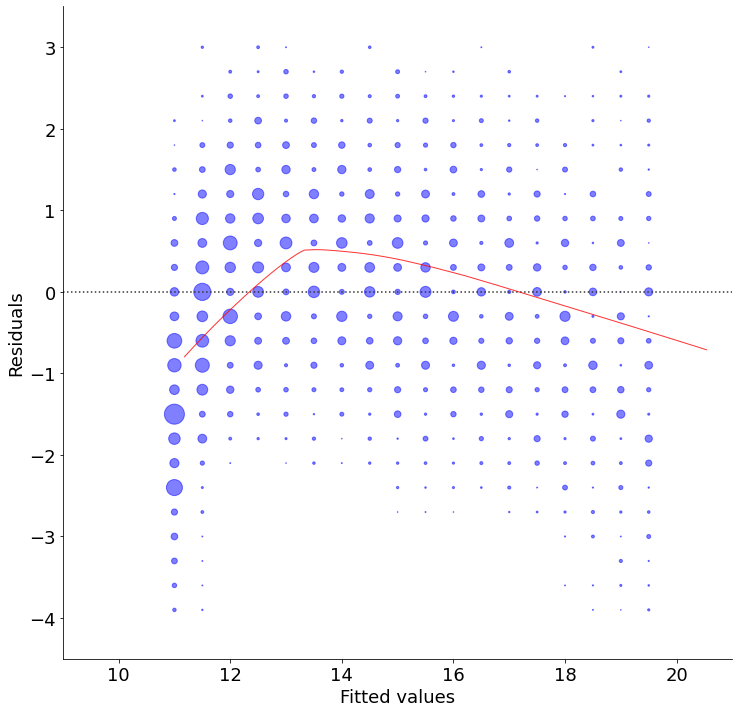

In [81]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot


df_m = pd.DataFrame({'X':X_train[:,0], 'Y':Y_train})

# generate OLS model
#model_fit = sm.OLS(pd.DataFrame({'Y':Y_train}), sm.add_constant(df_m)).fit()
model_fit = sm.OLS(pd.DataFrame({'Y':Y_train}), sm.add_constant(X_train[:,0])).fit()


# model values
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# density for residuals - fitted plot
X = model_fitted_y
Y = model_residuals

xvals = []
yvals = []
cvals = []
cuff_mask = (x_train[:,3]==1)

for x in np.arange(8, 20, 0.5):
    for y in np.arange(-3.9, 3.3, 0.3):
        xvals.append(x)
        yvals.append(y)
        
        
        
        cvals.append(sum((X >= x) & (X < x + 0.5) & (Y >= y) & (Y < y + 0.3)))
        #cvals_old.append(sum((y_test_old == x) & (y_test == y)))
xvals = np.array(xvals)
yvals = np.array(yvals)
cvals = np.array(cvals) / 2


# plot
UPPER_FIT = 20
LOWER_FIT = 10
INT_FIT = 2
UPPER_RES = 3
LOWER_RES = -4
INT_RES = 1

plot_settings()
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, df_m.columns[-1], data=df_m,
                          lowess=True,
                          scatter_kws={'alpha': 0},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].spines['top'].set_visible(False)
plot_lm_1.axes[0].spines['right'].set_visible(False)
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')
plot_lm_1.axes[0].set_xlim(LOWER_FIT - INT_FIT / 2, UPPER_FIT + INT_FIT / 2)
plot_lm_1.axes[0].set_ylim(LOWER_RES - INT_RES / 2, UPPER_RES + INT_RES / 2)
plot_lm_1.axes[0].set_xticks(np.arange(LOWER_FIT, UPPER_FIT + INT_FIT, INT_FIT), [f'{y}' for y in np.arange(LOWER_FIT, UPPER_FIT+INT_FIT, INT_FIT)])
plot_lm_1.axes[0].set_yticks(np.arange(LOWER_RES,UPPER_RES + INT_RES, INT_RES))

plot_lm_1.axes[0] = plt.scatter(xvals, yvals, c='blue', alpha=0.5, s=cvals)
plt.savefig("figures/Fig3_f_residuals.png", dpi=600)

In [193]:
X.min(), X.max()

(10.96837428358726, 18.959093733681563)

### Anderson Darling test (checking noramlity of residuals)

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/home/painstudy/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


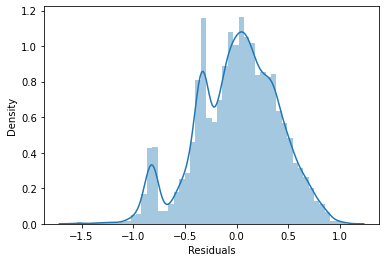


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [92]:
cmask = x_train[:,4]==0
X_train = x_train[cmask]
Y_train = y_train[cmask]

linear_x, linear_y = X_train[:,0].reshape(-1,1), Y_train

linear_model = LinearRegression()
linear_model.fit(linear_x, linear_y)

normal_errors_assumption(linear_model, linear_x, linear_y)

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 1.1964321391636765e-15
Residuals are not normally distributed


/home/painstudy/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


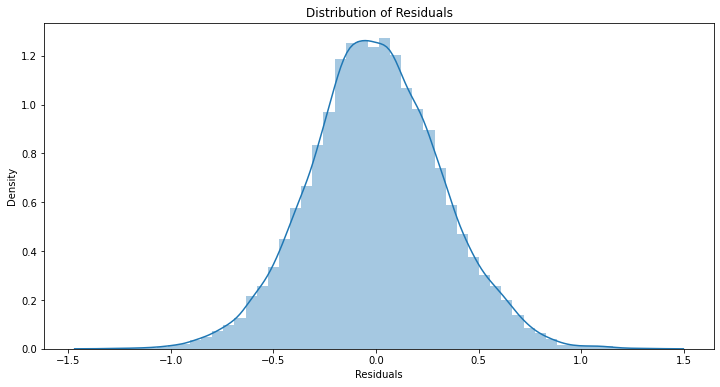


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [73]:
linear_x = x_train

normal_errors_assumption(linear_model, linear_x, linear_y)

## Multicollinearity

In [69]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

x_train: (24764, 4), x_test: (6190, 4)
Assumption 3: Little to no multicollinearity among predictors


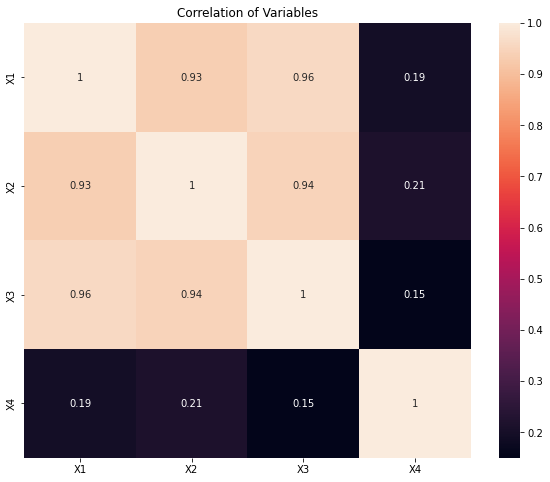

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X1: 15.396582915611317
X2: 38.78300884693787
X3: 14.774369168355758
X4: 1.4457245972751462

3 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)


In [72]:
# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

print(f'x_train: {x_train_imputed.shape}, x_test: {x_test_imputed.shape}')


linear_x = x_train_imputed
linear_y = y_train

linear_model = LinearRegression()
linear_model.fit(linear_x, linear_y)


linear_feature_names = ['X'+str(feature+1) for feature in range(linear_x.shape[1])]

multicollinearity_assumption(linear_model, linear_x, linear_y, linear_feature_names)

In [23]:
import gdown

gurl = 'https://drive.google.com/uc?id=11ZzADbIeMY5jUcoHxSVdsO4nun9WVKEO'
gdown.download(gurl, 'AvenirLTProLight.otf')

Downloading...
From: https://drive.google.com/uc?id=11ZzADbIeMY5jUcoHxSVdsO4nun9WVKEO
To: /home/painstudy/dl_ETT/AvenirLTProLight.otf
100%|██████████| 44.3k/44.3k [00:00<00:00, 836kB/s]


'AvenirLTProLight.otf'